# **Natural Language Understanding Project**

*Student name: Andrea Bonora*

*Identification number: 232222*



This project has as its purpose the implementation of a Language Model using a Recurrent Neural Network (RNN) architecture which can reach a perplexity below $90.7$ on the Penn TreeBank (PTB) dataset

# Imports

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
from functools import wraps
from collections import defaultdict
import time
import math
import numpy as np
import os
import hashlib
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [3]:
#@title Paths
#@markdown Insert value for the following parameters

dataset_path = '/content/drive/MyDrive/NLU_project/ptbdataset.zip' #@param {type: "string"}
models_path = '/content/drive/MyDrive/NLU_project/models' #@param {type: "string"}
logs_dir = '/content/drive/MyDrive/NLU_project/writers' #@param {type: "string"}
#@markdown ---

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Utils

This section contains some functions that are useful to load the dataset, create the dictionary, and collect statistics on the dataset.

In [5]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add_word(self, word: str):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)

In [6]:
class Corpus(object):
    def __init__(self, path:str):
        self.dictionary = Dictionary()

        train = self.tokenize(os.path.join(path, 'ptb.train.txt'))
        self.train = train[0]
        self.train.words = train[1]
        self.train.vocab = set(train[1])
        self.train.sents = train[2]

        valid = self.tokenize(os.path.join(path, 'ptb.valid.txt'))
        self.valid = valid[0]
        self.valid.words = valid[1]
        self.valid.vocab = set(valid[1])
        self.valid.sents = valid[2]

        test = self.tokenize(os.path.join(path, 'ptb.test.txt'))
        self.test = test[0]
        self.test.words = test[1]
        self.test.vocab = set(test[1])
        self.test.sents = test[2]

    def tokenize(self, path:str):
        words_vec = []
        sents_vec = []
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r', encoding="utf8") as f:
            for line in f:
                sents_vec.append(line.split())
                words = line.split() + ['<eos>']
                for word in words:
                  if word != '<eos>':
                    words_vec.append(word)
                  self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r', encoding="utf8") as f:
            idss = []
            for line in f:
                words = line.split() + ['<eos>']
                ids = []
                for word in words:
                    ids.append(self.dictionary.word2idx[word])
                idss.append(torch.tensor(ids).type(torch.int64))
            ids = torch.cat(idss)

        return ids, words_vec, sents_vec

In [7]:
import pandas
def create_table(table, names_col:str=None):
  if names_col is None:
    df = pandas.DataFrame.from_dict(table, orient='index')
  else:
    df = pandas.DataFrame.from_dict(table, orient='index', columns = names_col)
  return df

In [8]:
def sentences_statistics(sents:list):
  max = average = 0
  min = 10000
  for i in range(len(sents)):
    if len(sents[i]) < min:
      min = len(sents[i])

    if len(sents[i]) > max:
      max = len(sents[i])
    
    average += len(sents[i])

  return {"Number of sentences":i+1,
          "Min number of words":min,
          "Max number of words":max,
          "Average number of words per sentence":average//len(sents)}

# Dataset analysis

Penn TreeBank is one of the most used benchmark dataset when it comes to language modeling. The Penn Treebank project is composed of 2,499 stories selected from the Wall Street Journal. 

This section of the notebook aims to analyze all the aspects of the PTB dataset in order to have a clear vision before starting to design the RNN.

In [9]:
!cp -r $dataset_path ./ptbdataset.zip

In [10]:
!unzip "/content/ptbdataset.zip"

Archive:  /content/ptbdataset.zip
  inflating: ptbdataset/ptb.char.test.txt  
  inflating: ptbdataset/ptb.char.train.txt  
  inflating: ptbdataset/ptb.char.valid.txt  
  inflating: ptbdataset/ptb.test.txt  
  inflating: ptbdataset/ptb.train.txt  
  inflating: ptbdataset/ptb.valid.txt  
  inflating: ptbdataset/README       


In [11]:
source = "/content/ptbdataset"
corpus = Corpus(source)

For the initial study of the PTB dataset, the number of words and the size of the vocabulary has been computed. It is possible to notice, here below, that the train set has a much higher number of words with respect to the valid and test set (about 12 times more words), but the vocabulary sizes are similar. (In the vocabulary sizes reported below also the $<eos>$ tag has been counted).

In [12]:
print(len(corpus.train.words))
print(len(corpus.valid.words))
print(len(corpus.test.words))

887521
70390
78669


In [13]:
print(len(corpus.train.vocab))
print(len(corpus.valid.vocab))
print(len(corpus.test.vocab))

9999
6021
6048


A crucial thing when it comes to language modeling is to understand if the are out-of-vocabulary words (OOV) which are unknown words that appear in the validation/test set but not in the training vocabulary. The presence of OOV words could introduce some difficulties in the model training. Fortunately, there are no OOV words in this dataset.

In [14]:
print(len(corpus.valid.vocab.difference(corpus.train.vocab)))

0


In [15]:
print(len(corpus.test.vocab.difference(corpus.train.vocab)))

0


Next, an analysis of the words that have the highest frequency has been made. It is possible to notice that (excluding the $<eos>$ tag) the three most frequent words are the same for all the different sets. In particular, the $<unk>$ tag is always at least in the first two places in the ranking. The $<unk>$ tag is used to represent words that occur infrequently or don't meet a certain frequency threshold

In [16]:
import nltk
def top_k_most_frequent_words(words:list, k:int = 10):
  fl = nltk.FreqDist(words)
  return dict(sorted(fl.items(), key=lambda item: item[1], reverse=True)[:k])

In [17]:
create_table(top_k_most_frequent_words(corpus.train.words, 10), ["Number of times"])

Number of times
the              50770
<unk>            45020
N                32481
of               24400
to               23638
a                21196
in               18000
and              17474
's                9784
that              8931

In [18]:
create_table(top_k_most_frequent_words(corpus.valid.words, 10), ["Number of times"])

Number of times
the               4122
<unk>             3485
N                 2603
of                1832
to                1750
a                 1738
in                1392
and               1391
's                 868
for                726

In [19]:
create_table(top_k_most_frequent_words(corpus.test.words, 10), ["Number of times"])

Number of times
<unk>             4794
the               4529
N                 2523
of                2195
to                2042
a                 1821
in                1640
and               1539
's                 903
that               831

Furthermore, I tried to investigate if there are words with capital letters in them, but trying to produce a vocabulary using all the words converted into small letters lead to having a vocabulary of the same size, this means that all the words are in lower case.

Finally, I also collect statistics on the sentences, which are reported below.



In [20]:
print(len(corpus.train.vocab), len(set([w.lower() for w in corpus.train.vocab])))
print(len(corpus.valid.vocab), len(set([w.lower() for w in corpus.valid.vocab])))
print(len(corpus.test.vocab), len(set([w.lower() for w in corpus.test.vocab])))

9999 9999
6021 6021
6048 6048


In [21]:
sents = {}
sents['train'] = sentences_statistics(corpus.train.sents)
sents['valid'] = sentences_statistics(corpus.valid.sents)
sents['test'] = sentences_statistics(corpus.test.sents)
create_table(sents)

Number of sentences  Min number of words  Max number of words  \
train                42068                    1                   82   
valid                 3370                    1                   74   
test                  3761                    1                   77   

       Average number of words per sentence  
train                                    21  
valid                                    20  
test                                     20

# Model Utils

This section includes functions that are used for training the model

In [22]:
def repackage_hidden(h: torch.Tensor):
    """Wraps hidden states in new Tensors,
    to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [23]:
def batchify(data, bsz: int):
    
    nbatch = data.size(0) // bsz
    data = data.narrow(0, 0, nbatch * bsz)
    data = data.view(bsz, -1).t().contiguous()

    return data

In [24]:
def get_batch(source, i:int, seq_len:int=None, bptt:int = None):
    seq_len = min(seq_len if seq_len else bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

In [25]:
def model_save(path:str, model: nn.Module, criterion, optimizer):
    with open(path, 'wb') as f:
        torch.save([model, criterion, optimizer], f)

In [26]:
def model_load(path:str):
    with open(path, 'rb') as f:
        model, criterion, optimizer = torch.load(f)
    return model, criterion, optimizer

In [27]:
def get_optimizer(type: str, model: nn.Module, lr: float, wdecay:float = 0, t0:float = 1e6, lambd:tuple=(0.9, 0.999)):
  if type == "SGD":
    return torch.optim.SGD(model.parameters(), lr=lr, weight_decay= wdecay)
  elif type == "ASGD":
    return torch.optim.ASGD(model.parameters(), lr=lr,  t0=0, lambd=0., weight_decay = wdecay)
  elif type == "Adam":
    return torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))

In [28]:
def set_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

# Train and Test

In [29]:
def train(train_data, model:nn.Module, criterion, optimizer:any, batch_size:int, epoch:int, device = 'cpu', bptt:int = None, variable_length:bool = False, AWS:bool = False, alpha:float = None, beta:float = None):

    total_loss = 0
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(batch_size)
    batch, i = 0, 0
    model.train()
    if bptt is None:
      bptt = batch_size
    pbar = tqdm(total=train_data.size(0) - 1 - 1, position = 0, leave = False)
    while i < train_data.size(0) - 1 - 1:
                
        if variable_length:
          bptt = bptt if np.random.random() < 0.95 else bptt / 2.
          seq_len = max(5, int(np.random.normal(bptt, 5))) # Prevent excessively small or negative sequence lengths

          lr2 = optimizer.param_groups[0]['lr']
          optimizer.param_groups[0]['lr'] = lr2 * seq_len / bptt
          data, targets = get_batch(train_data, i, seq_len=seq_len, bptt=bptt)

        else:
          data, targets = get_batch(train_data, i, bptt=bptt)
        
        data = data.to(device)
        targets = targets.to(device)

        hidden = repackage_hidden(hidden)
        optimizer.zero_grad()

        if AWS:
          output, hidden, rnn_hs, dropped_rnn_hs = model(data, hidden, return_h=True)
          raw_loss = criterion(model.decoder.weight, model.decoder.bias, output, targets)
          loss = raw_loss
          # Activiation Regularization
          if alpha: loss = loss + sum(alpha * dropped_rnn_h.pow(2).mean() for dropped_rnn_h in dropped_rnn_hs[-1:])
          # Temporal Activation Regularization
          if beta: loss = loss + sum(beta * (rnn_h[1:] - rnn_h[:-1]).pow(2).mean() for rnn_h in rnn_hs[-1:])

        else:
          output, hidden = model(data, hidden)
          raw_loss = criterion(output, targets)
          loss = raw_loss

        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip: torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        total_loss += loss.data
        
        if variable_length:
          optimizer.param_groups[0]['lr'] = lr2

        batch += 1
        i += bptt
        pbar.update(bptt)

    cur_loss = total_loss.item() / batch

    print('| epoch {:3d} | lr {:05.5f} | loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, optimizer.param_groups[0]['lr'], cur_loss, math.exp(cur_loss)))
    pbar.close()
    return cur_loss

In [30]:
def evaluate(data_source, model:nn.Module, criterion, eval_batch_size:int, bptt:int = None, device = 'cpu', AWS:bool = False):
    model.eval()
    total_loss = 0
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(eval_batch_size)
    if bptt is None:
      bptt = eval_batch_size

    for i in range(0, data_source.size(0) - 1, bptt):
        
        data, targets = get_batch(data_source, i, bptt = bptt)
        
        data = data.to(device)
        targets = targets.to(device)
        output, hidden = model(data, hidden)

        if AWS:
          total_loss += len(data) * criterion(model.decoder.weight, model.decoder.bias, output, targets).data
        else:
          total_loss += len(data) * criterion(output, targets).data

        hidden = repackage_hidden(hidden)
        
    return total_loss.item() / len(data_source)

In [31]:
def test(model:nn.Module, criterion, test_data, test_batch_size:int, device = 'cpu', bptt:int = None, AWS:bool = False):
  test_loss = evaluate(test_data, model, criterion, test_batch_size, bptt = bptt, device = device, AWS = AWS)
  print('=' * 89)
  print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
      test_loss, math.exp(test_loss)))
  print('=' * 89)

In [32]:
def main(model: nn.Module, corpus = None, initial_lr:float = 30, model_type:str = "LSTM", optimizer_type:str = 'SGD', criterion = None, epochs:int = 50, train_bsz:int = 70, eval_bsz:int = 10, test_bsz:int = 1, use_asgd:bool = False, \
         nonmono:int = None, bptt:int = None, variable_length:bool = False, AWS:bool = False, alpha:float = None, beta:float = None, no_imp:int = 4, early_stopping:int = 6, wdecay:float = 0, t0:float = 1e6, \
         lambd:tuple=(0.9, 0.999), test_mode:bool = False):
  # Set the random seed manually for reproducibility.
  device = set_device()
  np.random.seed(seed)
  torch.manual_seed(seed)
  if device == torch.device("cuda"): torch.cuda.manual_seed(seed)

  train_batch_size = train_bsz
  eval_batch_size = eval_bsz
  test_batch_size = test_bsz
  train_data = batchify(corpus.train, train_batch_size)
  val_data = batchify(corpus.valid, eval_batch_size)
  test_data = batchify(corpus.test, test_batch_size)

  if test_mode:
    if use_asgd:
      try:
        model, criterion, _ = model_load(models_path + "/best_model_asgd_" + model_type)
      except:
        model, criterion, _ = model_load(models_path + "/best_model_" + model_type)
    else:
      model, criterion, _ = model_load(models_path + "/best_model_" + model_type)
    test(model, criterion, test_data, test_batch_size, device, bptt, AWS)
    return

  if not criterion:
    criterion = nn.CrossEntropyLoss()

  optimizer = None
  ntokens = len(corpus.dictionary)

  model = model.to(device)
  criterion = criterion.to(device)

  #Compute number of parameters of the model
  params = list(model.parameters()) + list(criterion.parameters())
  total_params = sum(x.size()[0] * x.size()[1] if len(x.size()) > 1 else x.size()[0] for x in params if x.size())
  print('Model total parameters:', total_params)

  # Loop over epochs.
  lr = initial_lr
  best_val_loss = []
  stored_loss = 100000000
  step_w_no_imp = 0
  
  if not optimizer:
        optimizer = get_optimizer(optimizer_type, model, initial_lr, wdecay=wdecay, t0 = t0, lambd = lambd)
        
  switched_to_asgd = False

  writer = SummaryWriter(logs_dir)

  pbar = tqdm(range(1, epochs+1),position=0, leave=False)
  for p, epoch in zip(pbar,range(1, epochs+1)):

          epoch_start_time = time.time()
          train_loss = train(train_data, model, criterion, optimizer, train_batch_size, epoch, device = device, bptt = bptt, AWS = AWS, alpha = alpha, beta = beta)
          writer.add_scalar('Loss/train', train_loss, epoch)
          writer.add_scalar('Perplexity/train', train_loss, epoch)
          if switched_to_asgd:
              val_loss2 = evaluate(val_data, model, criterion, eval_batch_size, device = device, bptt = bptt, AWS = AWS)
              print('-' * 89)
              print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                  'valid ppl {:8.2f} | valid bpc {:8.3f}'.format(
                      epoch, (time.time() - epoch_start_time), val_loss2, math.exp(val_loss2), val_loss2 / math.log(2)))
              print('-' * 89)

              if val_loss2 < stored_loss:
                  model_save(models_path + "/best_model_asgd_" + model_type, model, criterion, optimizer)
                  print('Saving Averaged!')
                  stored_loss = val_loss2
                  step_w_no_imp = 0
              else:
                  step_w_no_imp += 1
              
              #early stopping
              if step_w_no_imp >= early_stopping:
                print('Early stopping')
                print('Saving last model before ending training')
                model_save(models_path+"/last_model_" + model_type, model, criterion, optimizer)
                break

          else:
              val_loss = evaluate(val_data, model, criterion, eval_batch_size, device = device, bptt = bptt, AWS = AWS)
              writer.add_scalar('Loss/valid', val_loss, epoch)
              writer.add_scalar('Perplexity/valid', math.exp(val_loss), epoch)
              print('-' * 89)
              print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                  'valid ppl {:8.2f}'.format(
                epoch, (time.time() - epoch_start_time), val_loss, math.exp(val_loss)))
              print('-' * 89)

              if val_loss < stored_loss:
                  model_save(models_path+"/best_model_" + model_type, model, criterion, optimizer)
                  print('Saving model (new best validation)')
                  stored_loss = val_loss
                  step_w_no_imp = 0
              else:
                  step_w_no_imp += 1

              if optimizer_type == 'SGD' and not switched_to_asgd and use_asgd and (len(best_val_loss)>nonmono and \
                                                                                  val_loss > min(best_val_loss[:-nonmono])):
                  print('Switching to ASGD')
                  optimizer = torch.optim.ASGD(model.parameters(), lr=optimizer.param_groups[0]['lr'], t0=t0, lambd=lambd, weight_decay=wdecay)
                  switched_to_asgd = True

              #lr decreasing
              if step_w_no_imp >= no_imp and step_w_no_imp % no_imp == 0:
                print('Saving model before learning rate decreased')
                model_save(models_path+"/before_decresing_lr", model, criterion, optimizer)
                optimizer.param_groups[0]['lr'] /= 10.
              
              #early stopping
              if step_w_no_imp >= early_stopping:
                print('Early stopping')
                print('Saving last model before ending training')
                model_save(models_path+"/last_model_" + model_type, model, criterion, optimizer)
                break


              best_val_loss.append(val_loss)
          model_save(models_path+"/last_model_" + model_type, model, criterion, optimizer)

# Parameters

In [34]:
#@title Parameters
#@markdown Insert value for the following parameters

emsize = 650 #@param {type: "number"}
nhid = 650 #@param {type: "number"}
nlayers = 3 #@param {type: "slider", min: 1, max: 5}
seed = 1111
initial_lr = 30 #@param {type: "number"}
bptt = 70 #@param {type: "number"}
clip = 0.25 #@param {type: "number"}
wdecay = 0.0000012 #@param {type: "number"}
#@markdown ---

# Standard LSTM

Standard LSTM is the first model tried to achieve the task of this project. It is the very basic implementation of LSTM that used the $nn.LSTM$ module provided by PyTorch. This model, as all the others that will be presented later, will use an embedding size of 650, a hidden size of 650, and 3 layers.

In [35]:
class LSTM(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken:int, ninp:int, nhid:int, nlayers:int):
        super(LSTM, self).__init__()
      
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, num_layers=nlayers)
        self.decoder = nn.Linear(nhid, ntoken)

        self.init_weights()

        self.ninp = ninp
        self.nhid = nhid
        self.nlayers = nlayers
        self.ntoken = ntoken

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input:torch.Tensor, hidden:tuple):
        emb = self.encoder(input)
        output, hidden = self.rnn(emb, hidden)
        decoded = self.decoder(output)
        decoded = decoded.view(-1, self.ntoken)
        return F.log_softmax(decoded, dim=1), hidden

    def init_hidden(self, bsz:int):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                    weight.new_zeros(self.nlayers, bsz, self.nhid))

In [84]:
corpus = Corpus(source)
model = LSTM(len(corpus.dictionary), emsize, nhid, nlayers)
main(model, corpus = corpus, initial_lr = 30, model_type = "LSTM", optimizer_type = 'SGD', epochs = 50, train_bsz = 20, eval_bsz = 10, test_bsz = 1, use_asgd = False, wdecay = wdecay)

Model total parameters: 23165600


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/46477 [00:00<?, ?it/s]

| epoch   1 | lr 30.00000 | loss  5.77 | ppl   320.92
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 60.26s | valid loss  5.28 | valid ppl   195.69
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/46477 [00:00<?, ?it/s]

| epoch   2 | lr 30.00000 | loss  4.94 | ppl   140.12
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 60.61s | valid loss  4.99 | valid ppl   147.61
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/46477 [00:00<?, ?it/s]

| epoch   3 | lr 30.00000 | loss  4.61 | ppl   100.38
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 58.33s | valid loss  4.90 | valid ppl   134.72
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/46477 [00:00<?, ?it/s]

| epoch   4 | lr 30.00000 | loss  4.34 | ppl    77.08
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 58.82s | valid loss  4.89 | valid ppl   133.54
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/46477 [00:00<?, ?it/s]

| epoch   5 | lr 30.00000 | loss  4.11 | ppl    61.14
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 57.37s | valid loss  4.90 | valid ppl   133.91
-----------------------------------------------------------------------------------------


  0%|          | 0/46477 [00:00<?, ?it/s]

| epoch   6 | lr 30.00000 | loss  3.92 | ppl    50.54
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 57.59s | valid loss  4.94 | valid ppl   140.32
-----------------------------------------------------------------------------------------


  0%|          | 0/46477 [00:00<?, ?it/s]

| epoch   7 | lr 30.00000 | loss  3.76 | ppl    43.12
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 58.86s | valid loss  4.99 | valid ppl   146.31
-----------------------------------------------------------------------------------------


  0%|          | 0/46477 [00:00<?, ?it/s]

| epoch   8 | lr 30.00000 | loss  3.64 | ppl    38.18
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 60.94s | valid loss  5.06 | valid ppl   158.35
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/46477 [00:00<?, ?it/s]

| epoch   9 | lr 3.00000 | loss  3.31 | ppl    27.33
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 59.72s | valid loss  5.04 | valid ppl   154.08
-----------------------------------------------------------------------------------------


  0%|          | 0/46477 [00:00<?, ?it/s]

| epoch  10 | lr 3.00000 | loss  3.02 | ppl    20.54
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 57.57s | valid loss  5.09 | valid ppl   162.32
-----------------------------------------------------------------------------------------
Early stopping
Saving last model before ending training


## Test and comments

As can be noticed, using a plain LSTM model is not enough. The perplexity reached is very high (+41.59 wrt. the baseline). Furthermore, the behavior of the model during training is not optimal, in fact, the model is able to perform very well on the train set but it provides very poor performance on the valid set. This brings the necessity to introduce some techniques to prevent overfitting. Finally, the valid perplexity starts to increase after only 6 epochs making the model stop the training after only 10 epochs thanks to early stopping.

In [37]:
corpus = Corpus(source)
model = LSTM(len(corpus.dictionary), emsize, nhid, nlayers)
main(model, corpus = corpus, model_type = "LSTM", test_bsz = 1, test_mode=True)

| End of training | test loss  4.88 | test ppl   131.09


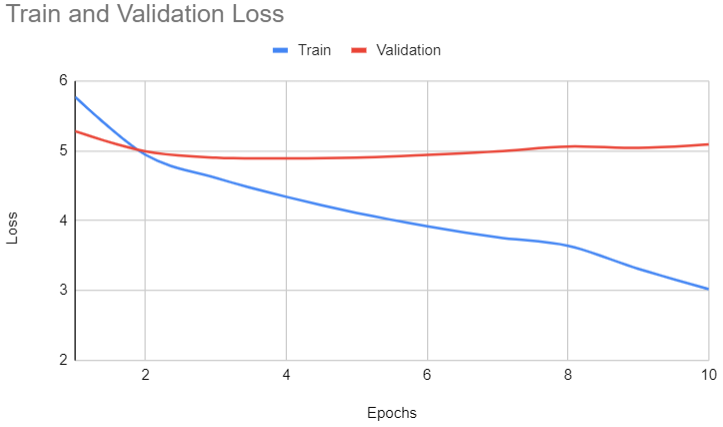

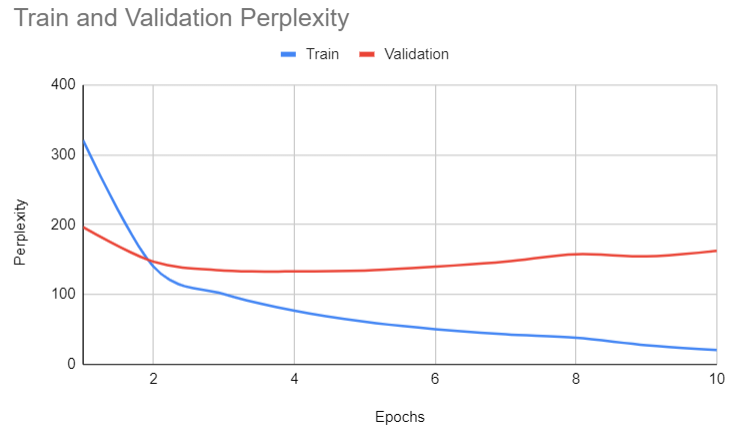

# LSTM + Dropout

The first technique tried to reduce overfitting is dropout which is a "*technique that has proven to be an effective mechanism for regularization and preventing the co-adaptation of neurons*". [[PyTorch Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)]

In [38]:
class LSTM_dropout(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken:int, ninp:int, nhid:int, nlayers:int, dropout:float):
        super(LSTM_dropout, self).__init__()
      
        self.dropout = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, num_layers=nlayers)
        self.decoder = nn.Linear(nhid, ntoken)

        self.init_weights()

        self.ninp = ninp
        self.nhid = nhid
        self.nlayers = nlayers
        self.ntoken = ntoken

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input:torch.Tensor, hidden:tuple):
        emb = self.dropout(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        decoded = self.decoder(self.dropout(output))
        decoded = decoded.view(-1, self.ntoken)
        return F.log_softmax(decoded, dim=1), hidden

    def init_hidden(self, bsz:int):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                    weight.new_zeros(self.nlayers, bsz, self.nhid))

In [ ]:
dropout = 0.5
corpus = Corpus(source)
model = LSTM_dropout(len(corpus.dictionary), emsize, nhid, nlayers, dropout)
main(model, corpus = corpus, initial_lr = 30, model_type = "LSTM_dropout", optimizer_type = 'SGD', epochs = 50, train_bsz = 70, eval_bsz = 10, test_bsz = 1, use_asgd = False, wdecay = wdecay)

Model total parameters: 23165600


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   1 | lr 30.00000 | loss  7.11 | ppl  1224.29
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 47.61s | valid loss  6.43 | valid ppl   622.90
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   2 | lr 30.00000 | loss  6.33 | ppl   559.21
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 46.17s | valid loss  6.06 | valid ppl   427.51
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   3 | lr 30.00000 | loss  6.00 | ppl   405.31
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 46.98s | valid loss  5.78 | valid ppl   323.21
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   4 | lr 30.00000 | loss  5.71 | ppl   301.33
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 46.59s | valid loss  5.52 | valid ppl   250.71
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   5 | lr 30.00000 | loss  5.48 | ppl   240.31
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 46.82s | valid loss  5.32 | valid ppl   205.34
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   6 | lr 30.00000 | loss  5.29 | ppl   198.68
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 47.12s | valid loss  5.17 | valid ppl   176.18
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   7 | lr 30.00000 | loss  5.13 | ppl   169.81
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 47.17s | valid loss  5.08 | valid ppl   161.55
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   8 | lr 30.00000 | loss  5.00 | ppl   148.97
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 46.90s | valid loss  4.97 | valid ppl   143.62
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   9 | lr 30.00000 | loss  4.89 | ppl   132.39
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 46.85s | valid loss  4.90 | valid ppl   134.91
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  10 | lr 30.00000 | loss  4.79 | ppl   119.84
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 46.96s | valid loss  4.84 | valid ppl   125.92
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  11 | lr 30.00000 | loss  4.70 | ppl   109.66
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 47.02s | valid loss  4.83 | valid ppl   125.09
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  12 | lr 30.00000 | loss  4.61 | ppl   100.64
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 47.05s | valid loss  4.80 | valid ppl   121.24
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  13 | lr 30.00000 | loss  4.53 | ppl    92.77
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 47.19s | valid loss  4.76 | valid ppl   117.18
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  14 | lr 30.00000 | loss  4.45 | ppl    85.66
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 47.21s | valid loss  4.74 | valid ppl   113.99
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  15 | lr 30.00000 | loss  4.39 | ppl    80.29
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 47.14s | valid loss  4.74 | valid ppl   114.96
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  16 | lr 30.00000 | loss  4.31 | ppl    74.29
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 47.10s | valid loss  4.71 | valid ppl   111.36
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  17 | lr 30.00000 | loss  4.24 | ppl    69.75
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 47.09s | valid loss  4.74 | valid ppl   113.87
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  18 | lr 30.00000 | loss  4.18 | ppl    65.20
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 47.13s | valid loss  4.75 | valid ppl   115.62
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  19 | lr 30.00000 | loss  4.11 | ppl    60.98
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 47.05s | valid loss  4.73 | valid ppl   113.18
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  20 | lr 30.00000 | loss  4.06 | ppl    57.83
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 47.04s | valid loss  4.74 | valid ppl   114.44
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  21 | lr 3.00000 | loss  3.83 | ppl    45.99
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 46.98s | valid loss  4.68 | valid ppl   107.53
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  22 | lr 3.00000 | loss  3.74 | ppl    42.25
-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 46.99s | valid loss  4.68 | valid ppl   107.71
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  23 | lr 3.00000 | loss  3.70 | ppl    40.54
-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 47.10s | valid loss  4.68 | valid ppl   108.07
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  24 | lr 3.00000 | loss  3.67 | ppl    39.15
-----------------------------------------------------------------------------------------
| end of epoch  24 | time: 47.14s | valid loss  4.69 | valid ppl   108.87
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  25 | lr 3.00000 | loss  3.64 | ppl    37.99
-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 47.22s | valid loss  4.69 | valid ppl   109.24
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  26 | lr 0.30000 | loss  3.61 | ppl    36.91
-----------------------------------------------------------------------------------------
| end of epoch  26 | time: 47.07s | valid loss  4.68 | valid ppl   108.20
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  27 | lr 0.30000 | loss  3.60 | ppl    36.62
-----------------------------------------------------------------------------------------
| end of epoch  27 | time: 47.06s | valid loss  4.68 | valid ppl   108.11
-----------------------------------------------------------------------------------------
Early stopping
Saving last model before ending training


## Test and comments

Adding dropout to the previous model lead to an improvement in terms of performance. But the perplexity achieved ($105.15$) is still over the baseline and the overfitting is still present. Also in this experiment, early stopping made the training stop before the 50th epoch.

In [40]:
corpus = Corpus(source)
model = LSTM_dropout(len(corpus.dictionary), emsize, nhid, nlayers, dropout = 0)
main(model, corpus = corpus, model_type = "LSTM_dropout", test_bsz = 1, test_mode = True)

| End of training | test loss  4.66 | test ppl   105.15


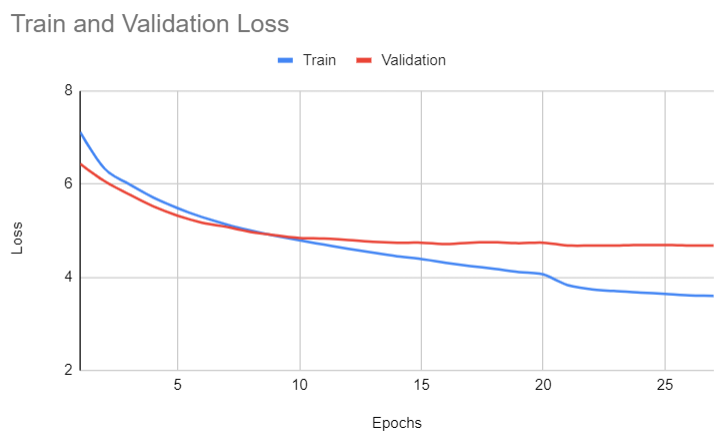

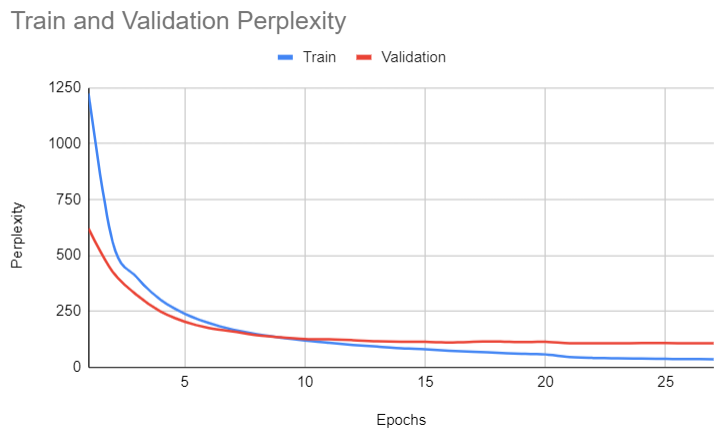

# LSTM + Dropout + Tied weights

From now on all the models will use tied weights as proposed by [Inan et al. (2016)](https://arxiv.org/pdf/1611.01462.pdf). Tying weights means that the encoder and the decoder will use the same value for their parameters. This technique lead to an improvements in performance as shown below. 

In [41]:
class LSTM_dropout_tied(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken:int, ninp:int, nhid:int, nlayers:int, dropout:float):
        super(LSTM_dropout_tied, self).__init__()
      
        self.dropout = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, num_layers=nlayers)
        self.decoder = nn.Linear(nhid, ntoken)

        self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.ninp = ninp
        self.nhid = nhid
        self.nlayers = nlayers
        self.ntoken = ntoken

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input: torch.Tensor, hidden:tuple):
        emb = self.dropout(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        decoded = self.decoder(self.dropout(output))
        decoded = decoded.view(-1, self.ntoken)
        return F.log_softmax(decoded, dim=1), hidden

    def init_hidden(self, bsz:int):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                    weight.new_zeros(self.nlayers, bsz, self.nhid))

In [ ]:
dropout = 0.5
corpus = Corpus(source)
model = LSTM_dropout_tied(len(corpus.dictionary), emsize, nhid, nlayers, dropout)
main(model, corpus = corpus, initial_lr = 30, model_type = "LSTM_dropout_tied", optimizer_type = 'SGD', epochs = 50, train_bsz = 70, eval_bsz = 10, test_bsz = 1, use_asgd = False, wdecay = wdecay)

Model total parameters: 16665600


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   1 | lr 30.00000 | loss  7.09 | ppl  1202.58
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 47.49s | valid loss  6.44 | valid ppl   626.83
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   2 | lr 30.00000 | loss  6.23 | ppl   508.75
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 46.28s | valid loss  6.03 | valid ppl   416.96
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   3 | lr 30.00000 | loss  5.78 | ppl   323.90
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 47.03s | valid loss  5.58 | valid ppl   266.06
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   4 | lr 30.00000 | loss  5.48 | ppl   240.07
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 46.49s | valid loss  5.31 | valid ppl   202.49
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   5 | lr 30.00000 | loss  5.27 | ppl   193.48
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 46.65s | valid loss  5.16 | valid ppl   173.92
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   6 | lr 30.00000 | loss  5.09 | ppl   162.82
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 46.88s | valid loss  5.01 | valid ppl   149.41
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   7 | lr 30.00000 | loss  4.96 | ppl   142.07
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 47.09s | valid loss  4.92 | valid ppl   137.12
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   8 | lr 30.00000 | loss  4.83 | ppl   125.36
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 47.04s | valid loss  4.83 | valid ppl   124.96
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   9 | lr 30.00000 | loss  4.72 | ppl   112.22
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 46.97s | valid loss  4.79 | valid ppl   120.52
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  10 | lr 30.00000 | loss  4.63 | ppl   102.33
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 47.08s | valid loss  4.75 | valid ppl   115.86
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  11 | lr 30.00000 | loss  4.53 | ppl    93.15
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 46.97s | valid loss  4.71 | valid ppl   110.96
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  12 | lr 30.00000 | loss  4.45 | ppl    85.74
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 46.89s | valid loss  4.65 | valid ppl   104.56
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  13 | lr 30.00000 | loss  4.37 | ppl    79.40
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 46.94s | valid loss  4.65 | valid ppl   105.09
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  14 | lr 30.00000 | loss  4.30 | ppl    73.78
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 47.03s | valid loss  4.64 | valid ppl   103.55
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  15 | lr 30.00000 | loss  4.23 | ppl    68.60
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 47.00s | valid loss  4.65 | valid ppl   104.79
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  16 | lr 30.00000 | loss  4.17 | ppl    64.54
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 47.12s | valid loss  4.67 | valid ppl   107.05
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  17 | lr 30.00000 | loss  4.10 | ppl    60.45
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 47.17s | valid loss  4.65 | valid ppl   104.58
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  18 | lr 30.00000 | loss  4.05 | ppl    57.15
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 47.15s | valid loss  4.67 | valid ppl   106.81
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  19 | lr 3.00000 | loss  3.83 | ppl    46.10
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 46.94s | valid loss  4.58 | valid ppl    97.74
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  20 | lr 3.00000 | loss  3.76 | ppl    42.74
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 47.06s | valid loss  4.58 | valid ppl    97.73
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  21 | lr 3.00000 | loss  3.72 | ppl    41.11
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 47.19s | valid loss  4.59 | valid ppl    98.16
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  22 | lr 3.00000 | loss  3.68 | ppl    39.80
-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 46.86s | valid loss  4.59 | valid ppl    98.29
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  23 | lr 3.00000 | loss  3.66 | ppl    38.78
-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 46.95s | valid loss  4.59 | valid ppl    98.84
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  24 | lr 3.00000 | loss  3.63 | ppl    37.90
-----------------------------------------------------------------------------------------
| end of epoch  24 | time: 47.25s | valid loss  4.60 | valid ppl    99.26
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  25 | lr 0.30000 | loss  3.60 | ppl    36.76
-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 47.09s | valid loss  4.59 | valid ppl    98.37
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  26 | lr 0.30000 | loss  3.60 | ppl    36.58
-----------------------------------------------------------------------------------------
| end of epoch  26 | time: 47.06s | valid loss  4.59 | valid ppl    98.23
-----------------------------------------------------------------------------------------
Early stopping
Saving last model before ending training


## Test and comments

Using tied weights the performance continued to drop wrt. the previous models. Now the perplexity reached is very near to the baseline, but some further improvements need to be implemented to reach the goal of the project.

In [53]:
corpus = Corpus(source)
model = LSTM_dropout_tied(len(corpus.dictionary), emsize, nhid, nlayers, dropout=0)
main(model, corpus = corpus, model_type = "LSTM_dropout_tied", test_bsz = 1, test_mode = True)

| End of training | test loss  4.55 | test ppl    94.61


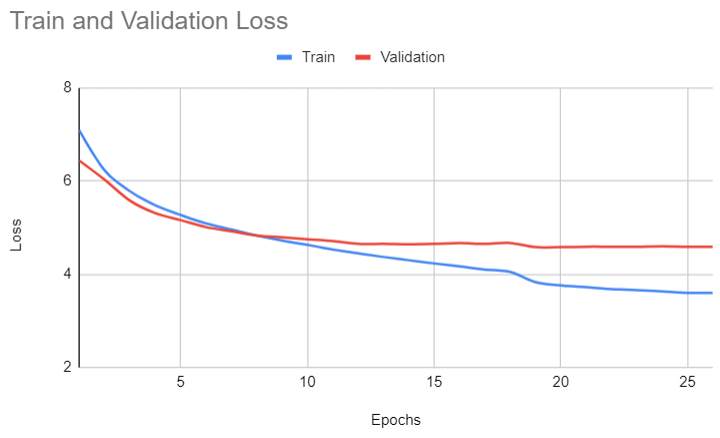

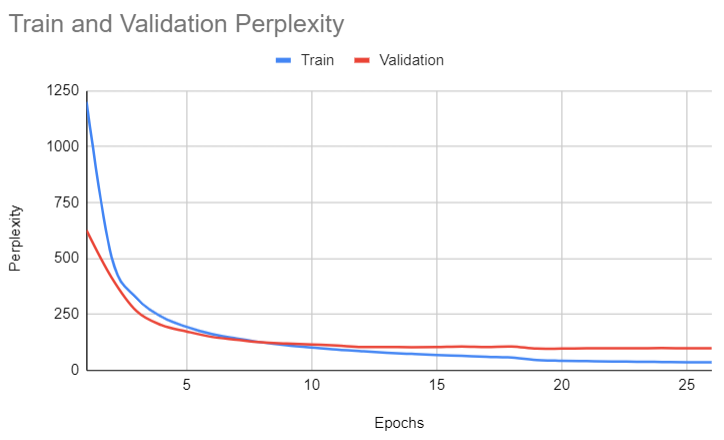

# LSTM + Dropout + Tied weights + Skip/Residual connections

A first trial has been done by trying to add skip/residual connections to the models. The idea is inspired by [Godin et al. (2017)](https://arxiv.org/pdf/1707.06130.pdf) which shows good performances implementing a densely connected LSTM.

In [43]:
class LSTM_dropout_tied_skipConnections(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken:int, ninp:int, nhid:int, nlayers:int, dropout:float):
        super(LSTM_dropout_tied_skipConnections, self).__init__()
      
        self.dropout = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnns = [torch.nn.LSTM(ninp if l == 0 else nhid, nhid if l != nlayers - 1 else ninp, 1, dropout=0) for l in range(nlayers)]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.decoder = nn.Linear(nhid, ntoken)
        self.skip = nn.Linear(ninp, nhid)

        if nhid != ninp:
          raise ValueError('When using the tied flag, nhid must be equal to emsize')
          self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.ninp = ninp
        self.nhid = nhid
        self.nlayers = nlayers
        self.ntoken = ntoken

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input: torch.Tensor, hidden:tuple):
        emb = self.dropout(self.encoder(input))
        
        raw_output = emb
        
        new_hidden = []

        for l, rnn in enumerate(self.rnns):
            input = raw_output
            rnn = rnn.to("cuda")
            raw_output, new_h = rnn(raw_output, hidden[l])
            new_hidden.append(new_h)
            
            if l != self.nlayers - 1:
                self.dropout(raw_output)

            #Skip connection
            if l >= 1:
              raw_output = torch.add(raw_output, input)

        decoded = self.decoder(self.dropout(raw_output))
        decoded = decoded.view(-1, self.ntoken)
        return F.log_softmax(decoded, dim=1), new_hidden

    def init_hidden(self, bsz:int):
        weight = next(self.parameters())
        return [(weight.new_zeros(1, bsz, self.nhid),
                    weight.new_zeros(1, bsz, self.nhid)) for l in range(self.nlayers)]

In [ ]:
dropout = 0.5
corpus = Corpus(source)
model = LSTM_dropout_tied_skipConnections(len(corpus.dictionary), emsize, nhid, nlayers, dropout)
main(model, corpus = corpus, initial_lr = 30, model_type = "LSTM_dropout_tied_skip", optimizer_type = 'SGD', epochs = 50, train_bsz = 70, eval_bsz = 10, test_bsz = 1, use_asgd = False, wdecay = wdecay)

Model total parameters: 23588750


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   1 | lr 30.00000 | loss  7.94 | ppl  2814.33
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 42.42s | valid loss  6.38 | valid ppl   589.17
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   2 | lr 30.00000 | loss  6.07 | ppl   434.42
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 41.65s | valid loss  5.71 | valid ppl   301.01
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   3 | lr 30.00000 | loss  5.63 | ppl   279.15
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 42.08s | valid loss  5.56 | valid ppl   259.76
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   4 | lr 30.00000 | loss  5.35 | ppl   210.33
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 42.13s | valid loss  5.22 | valid ppl   184.45
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   5 | lr 30.00000 | loss  5.15 | ppl   172.68
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 42.03s | valid loss  5.18 | valid ppl   176.85
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   6 | lr 30.00000 | loss  4.99 | ppl   147.07
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 42.11s | valid loss  4.93 | valid ppl   139.03
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   7 | lr 30.00000 | loss  4.86 | ppl   128.81
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 42.29s | valid loss  4.88 | valid ppl   131.14
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   8 | lr 30.00000 | loss  4.73 | ppl   113.12
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 42.29s | valid loss  4.77 | valid ppl   118.16
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   9 | lr 30.00000 | loss  4.62 | ppl   101.86
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 42.36s | valid loss  4.76 | valid ppl   116.65
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  10 | lr 30.00000 | loss  4.53 | ppl    92.43
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 42.16s | valid loss  4.69 | valid ppl   109.30
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  11 | lr 30.00000 | loss  4.43 | ppl    83.94
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 42.06s | valid loss  4.68 | valid ppl   107.33
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  12 | lr 30.00000 | loss  4.34 | ppl    77.09
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 42.16s | valid loss  4.65 | valid ppl   104.62
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  13 | lr 30.00000 | loss  4.27 | ppl    71.44
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 42.27s | valid loss  4.65 | valid ppl   104.95
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  14 | lr 30.00000 | loss  4.20 | ppl    66.73
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 42.41s | valid loss  4.64 | valid ppl   103.72
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  15 | lr 30.00000 | loss  4.12 | ppl    61.41
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 42.30s | valid loss  4.65 | valid ppl   104.73
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  16 | lr 30.00000 | loss  4.04 | ppl    57.07
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 42.43s | valid loss  4.65 | valid ppl   104.13
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  17 | lr 30.00000 | loss  3.98 | ppl    53.48
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 42.35s | valid loss  4.63 | valid ppl   102.62
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  18 | lr 30.00000 | loss  3.91 | ppl    49.76
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 42.41s | valid loss  4.67 | valid ppl   107.07
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  19 | lr 30.00000 | loss  3.84 | ppl    46.45
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 42.38s | valid loss  4.68 | valid ppl   108.28
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  20 | lr 30.00000 | loss  3.77 | ppl    43.57
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 42.30s | valid loss  4.69 | valid ppl   109.08
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  21 | lr 30.00000 | loss  3.70 | ppl    40.49
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 42.35s | valid loss  4.70 | valid ppl   110.17
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  22 | lr 3.00000 | loss  3.44 | ppl    31.19
-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 42.28s | valid loss  4.64 | valid ppl   103.92
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  23 | lr 3.00000 | loss  3.37 | ppl    28.99
-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 42.46s | valid loss  4.65 | valid ppl   104.65
-----------------------------------------------------------------------------------------
Early stopping
Saving last model before ending training


## Test and comments

Unfortunately, the results are not the ones expected. The final perplexity is worse than the previous one, meaning that this implementation of residual connections is not useful in this specific scenario.

In [55]:
corpus = Corpus(source)
model = LSTM_dropout_tied_skipConnections(len(corpus.dictionary), emsize, nhid, nlayers, dropout = 0)
main(model, corpus = corpus, model_type = "LSTM_dropout_tied_skip", test_bsz = 1, test_mode = True)

| End of training | test loss  4.60 | test ppl    99.13


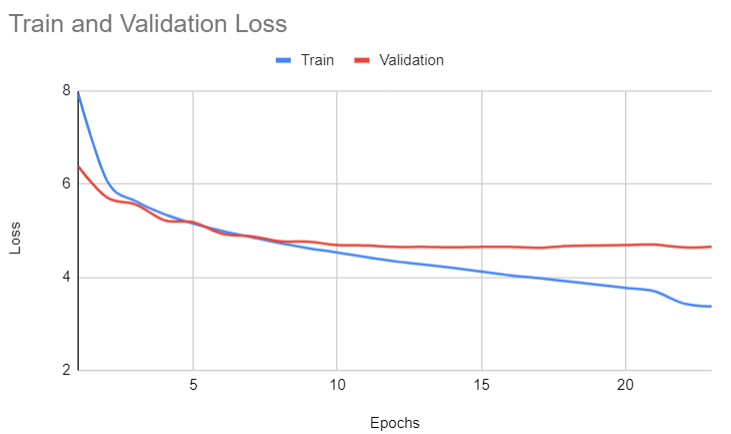

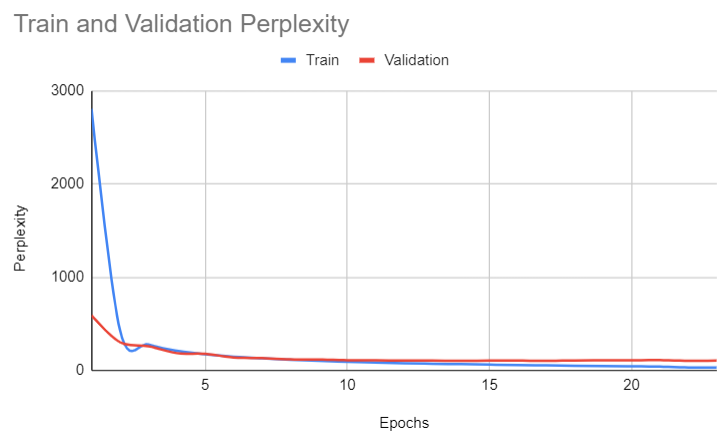

# LSTM + Dropout + Tied weights + ASGD

Inspired by [Merity et al. (2017)](https://arxiv.org/pdf/1708.02182.pdf) an implementation of the model using the averaged SGD (ASGD) has been done. The idea is to trigger the ASGD optimizer when the performances are at a standstill. When ASGD is triggered the learning rate will be kept constant until the end of the training, so no further tuning is necessary for the decay scheduling

In [80]:
dropout = 0.5
nonmono = 5
corpus = Corpus(source)
model = LSTM_dropout_tied(len(corpus.dictionary), emsize, nhid, nlayers, dropout)
main(model, corpus = corpus, initial_lr = 30, model_type = "LSTM_dropout_tied_asgd", use_asgd = True, nonmono = nonmono, optimizer_type = 'SGD', epochs = 50, bptt=bptt, train_bsz = 70, eval_bsz = 10, test_bsz = 1, wdecay = wdecay, t0=0, lambd=0.)

Model total parameters: 16665600


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   1 | lr 30.00000 | loss  7.12 | ppl  1234.23
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 48.19s | valid loss  6.55 | valid ppl   696.97
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   2 | lr 30.00000 | loss  6.24 | ppl   512.38
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 46.36s | valid loss  5.94 | valid ppl   380.23
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   3 | lr 30.00000 | loss  5.81 | ppl   334.74
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 47.37s | valid loss  5.62 | valid ppl   274.72
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   4 | lr 30.00000 | loss  5.51 | ppl   245.97
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 46.91s | valid loss  5.38 | valid ppl   216.28
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   5 | lr 30.00000 | loss  5.29 | ppl   197.97
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 47.00s | valid loss  5.13 | valid ppl   169.63
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   6 | lr 30.00000 | loss  5.12 | ppl   167.76
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 47.16s | valid loss  5.03 | valid ppl   153.23
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   7 | lr 30.00000 | loss  4.98 | ppl   145.52
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 47.33s | valid loss  4.92 | valid ppl   137.32
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   8 | lr 30.00000 | loss  4.86 | ppl   129.45
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 47.40s | valid loss  4.84 | valid ppl   126.35
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   9 | lr 30.00000 | loss  4.76 | ppl   116.45
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 47.33s | valid loss  4.78 | valid ppl   119.64
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  10 | lr 30.00000 | loss  4.66 | ppl   106.02
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 47.17s | valid loss  4.74 | valid ppl   113.92
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  11 | lr 30.00000 | loss  4.58 | ppl    97.04
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 47.21s | valid loss  4.72 | valid ppl   112.10
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  12 | lr 30.00000 | loss  4.50 | ppl    89.85
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 47.44s | valid loss  4.75 | valid ppl   115.60
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  13 | lr 30.00000 | loss  4.42 | ppl    83.21
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 47.43s | valid loss  4.65 | valid ppl   104.56
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  14 | lr 30.00000 | loss  4.35 | ppl    77.18
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 47.35s | valid loss  4.67 | valid ppl   106.47
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  15 | lr 30.00000 | loss  4.28 | ppl    72.22
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 47.25s | valid loss  4.63 | valid ppl   102.74
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  16 | lr 30.00000 | loss  4.22 | ppl    67.92
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 47.12s | valid loss  4.66 | valid ppl   105.49
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  17 | lr 30.00000 | loss  4.15 | ppl    63.71
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 47.22s | valid loss  4.65 | valid ppl   104.07
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  18 | lr 30.00000 | loss  4.09 | ppl    59.95
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 47.32s | valid loss  4.63 | valid ppl   102.77
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  19 | lr 30.00000 | loss  4.03 | ppl    56.36
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 47.49s | valid loss  4.63 | valid ppl   102.11
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  20 | lr 30.00000 | loss  3.99 | ppl    53.91
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 47.40s | valid loss  4.63 | valid ppl   102.94
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  21 | lr 30.00000 | loss  3.93 | ppl    50.81
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 47.45s | valid loss  4.67 | valid ppl   106.46
-----------------------------------------------------------------------------------------
Switching to ASGD


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  22 | lr 30.00000 | loss  3.87 | ppl    48.12
-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 47.72s | valid loss  4.67 | valid ppl   106.62 | valid bpc    6.736
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  23 | lr 30.00000 | loss  3.82 | ppl    45.56
-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 47.66s | valid loss  4.66 | valid ppl   105.32 | valid bpc    6.719
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  24 | lr 30.00000 | loss  3.76 | ppl    43.15
-----------------------------------------------------------------------------------------
| end of epoch  24 | time: 47.64s | valid loss  4.68 | valid ppl   107.61 | valid bpc    6.750
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  25 | lr 30.00000 | loss  3.71 | ppl    41.01
-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 47.70s | valid loss  4.70 | valid ppl   109.99 | valid bpc    6.781
-----------------------------------------------------------------------------------------
Early stopping
Saving last model before ending training


## Test and comments

Also in this case the results are not the one expected. Triggering ASGD helps in lowering the train perplexity, but the perplexity in the valid set starts to increase. At the end of the experiment, final performance does not improve and the test perplexity is still over the baseline.

In [83]:
corpus = Corpus(source)
model = LSTM_dropout_tied(len(corpus.dictionary), emsize, nhid, nlayers, dropout = 0)
main(model, corpus = corpus, model_type = "LSTM_dropout_tied_asgd", use_asgd = True, test_bsz = 1, test_mode = True)

| End of training | test loss  4.60 | test ppl    99.83


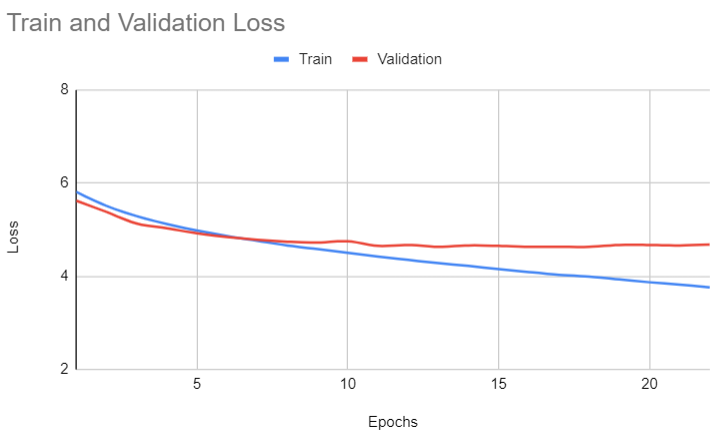

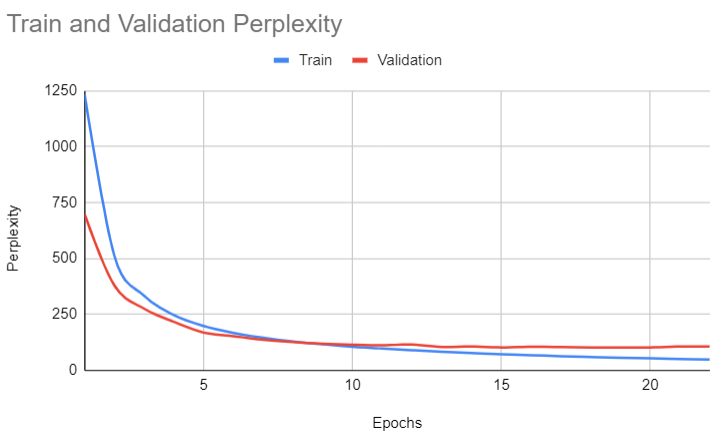

# LSTM + WeigthDrop

Seeing the previous results, skip connections and ASGD will not be used in the next models. 

The model introduced in this section is very similar to the simple LSTM with dropout showed before, but there is the addition of the DropConnect ([Wan et al. 2013](http://yann.lecun.com/exdb/publis/pdf/wan-icml-13.pdf)) as shown in [Merity et al. (2017)](https://arxiv.org/pdf/1708.02182.pdf). Performing DropConnect on the hidden-to-hidden weight matrices helps to prevent overfitting on the recurrent connections of the LSTM (ibidem).

To implement WeightDrop I used the code that can be found [here](https://github.com/salesforce/awd-lstm-lm/blob/master/weight_drop.py).

In [47]:
class WeightDrop(torch.nn.Module):
    def __init__(self, module, weights, dropout=0, variational=False):
        super(WeightDrop, self).__init__()
        self.module = module
        self.weights = weights
        self.dropout = dropout
        self.variational = variational
        self._setup()

    def widget_demagnetizer_y2k_edition(*args, **kwargs):
        return

    def _setup(self):
        if issubclass(type(self.module), torch.nn.RNNBase):
            self.module.flatten_parameters = self.widget_demagnetizer_y2k_edition

        for name_w in self.weights:
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(name_w + '_raw', Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = None
            if self.variational:
                mask = torch.autograd.Variable(torch.ones(raw_w.size(0), 1))
                if raw_w.is_cuda: mask = mask.cuda()
                mask = torch.nn.functional.dropout(mask, p=self.dropout, training=True)
                w = mask.expand_as(raw_w) * raw_w
            else:
                w = torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training)
            setattr(self.module, name_w, torch.nn.Parameter(w))

    def forward(self, *args):
        self._setweights()
        return self.module.forward(*args)

In [48]:
class LSTM_weightDropout(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken:int, ninp:int, nhid:int, nlayers:int, dropout:float, wdrop:float):
        super(LSTM_weightDropout, self).__init__()
      
        self.dropout = nn.Dropout(dropout)
        self.wdrop = wdrop
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = self.rnns = [torch.nn.LSTM(ninp if l == 0 else nhid, nhid if l != nlayers - 1 else nhid, 1, dropout=0) for l in range(nlayers)]
        self.rnns = [WeightDrop(rnn, ['weight_hh_l0'], dropout=wdrop) for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.decoder = nn.Linear(nhid, ntoken)

        if nhid != ninp:
          raise ValueError('When using the tied flag, nhid must be equal to emsize')
          self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.ninp = ninp
        self.nhid = nhid
        self.nlayers = nlayers
        self.ntoken = ntoken

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input:torch.Tensor, hidden:tuple):
        emb = self.dropout(self.encoder(input))
        raw_output = emb
        new_hidden = []

        for l, rnn in enumerate(self.rnns):
            rnn = rnn.to("cuda")
            raw_output, new_h = rnn(raw_output, hidden[l])
            new_hidden.append(new_h)
            
            if l != self.nlayers - 1:
                raw_output = self.dropout(raw_output)

        output = self.dropout(raw_output)
        decoded = self.decoder(output)
        decoded = decoded.view(-1, self.ntoken)
        return F.log_softmax(decoded, dim=1), new_hidden

    def init_hidden(self, bsz:int):
        weight = next(self.parameters())
        return [(weight.new_zeros(1, bsz, self.nhid),
                    weight.new_zeros(1, bsz, self.nhid)) for l in range(self.nlayers)]

In [ ]:
dropout = 0.4
wdrop = 0.5
corpus = Corpus(source)
model = LSTM_weightDropout(len(corpus.dictionary), emsize, nhid, nlayers, dropout, wdrop)
main(model, corpus = corpus, initial_lr = 30, model_type = "LSTM_weightDropout", optimizer_type = 'SGD', epochs = 50, bptt=bptt, train_bsz = 70, eval_bsz = 10, test_bsz = 1, use_asgd = False, wdecay=wdecay)

Model total parameters: 23165600


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   1 | lr 30.00000 | loss  7.23 | ppl  1383.16
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 43.87s | valid loss  6.62 | valid ppl   749.67
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   2 | lr 30.00000 | loss  6.58 | ppl   723.68
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 41.78s | valid loss  6.39 | valid ppl   595.03
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   3 | lr 30.00000 | loss  6.25 | ppl   519.66
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 42.37s | valid loss  6.02 | valid ppl   410.95
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   4 | lr 30.00000 | loss  5.98 | ppl   393.91
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 42.69s | valid loss  5.87 | valid ppl   353.29
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   5 | lr 30.00000 | loss  5.72 | ppl   305.78
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 42.37s | valid loss  5.61 | valid ppl   272.31
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   6 | lr 30.00000 | loss  5.52 | ppl   250.08
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 42.26s | valid loss  5.39 | valid ppl   218.38
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   7 | lr 30.00000 | loss  5.36 | ppl   212.77
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 42.40s | valid loss  5.28 | valid ppl   195.97
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   8 | lr 30.00000 | loss  5.23 | ppl   187.65
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 42.45s | valid loss  5.13 | valid ppl   168.75
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   9 | lr 30.00000 | loss  5.12 | ppl   167.98
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 42.59s | valid loss  5.06 | valid ppl   157.89
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  10 | lr 30.00000 | loss  5.03 | ppl   153.62
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 42.60s | valid loss  5.00 | valid ppl   148.70
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  11 | lr 30.00000 | loss  4.96 | ppl   142.50
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 42.78s | valid loss  4.95 | valid ppl   141.44
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  12 | lr 30.00000 | loss  4.89 | ppl   132.38
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 42.76s | valid loss  4.91 | valid ppl   135.65
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  13 | lr 30.00000 | loss  4.82 | ppl   124.12
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 42.73s | valid loss  4.86 | valid ppl   129.31
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  14 | lr 30.00000 | loss  4.77 | ppl   117.34
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 42.73s | valid loss  4.83 | valid ppl   125.47
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  15 | lr 30.00000 | loss  4.71 | ppl   111.18
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 42.79s | valid loss  4.79 | valid ppl   120.88
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  16 | lr 30.00000 | loss  4.66 | ppl   106.03
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 42.82s | valid loss  4.78 | valid ppl   119.58
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  17 | lr 30.00000 | loss  4.62 | ppl   101.06
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 42.67s | valid loss  4.75 | valid ppl   115.65
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  18 | lr 30.00000 | loss  4.57 | ppl    96.74
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 42.73s | valid loss  4.74 | valid ppl   113.98
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  19 | lr 30.00000 | loss  4.54 | ppl    93.73
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 42.89s | valid loss  4.71 | valid ppl   110.89
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  20 | lr 30.00000 | loss  4.50 | ppl    89.98
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 42.99s | valid loss  4.70 | valid ppl   110.45
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  21 | lr 30.00000 | loss  4.47 | ppl    87.01
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 42.74s | valid loss  4.68 | valid ppl   108.16
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  22 | lr 30.00000 | loss  4.43 | ppl    84.22
-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 42.71s | valid loss  4.69 | valid ppl   109.08
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  23 | lr 30.00000 | loss  4.40 | ppl    81.69
-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 42.90s | valid loss  4.66 | valid ppl   105.52
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  24 | lr 30.00000 | loss  4.37 | ppl    79.35
-----------------------------------------------------------------------------------------
| end of epoch  24 | time: 42.78s | valid loss  4.66 | valid ppl   105.36
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  25 | lr 30.00000 | loss  4.34 | ppl    77.08
-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 42.90s | valid loss  4.65 | valid ppl   104.28
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  26 | lr 30.00000 | loss  4.32 | ppl    75.41
-----------------------------------------------------------------------------------------
| end of epoch  26 | time: 42.90s | valid loss  4.62 | valid ppl   101.96
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  27 | lr 30.00000 | loss  4.29 | ppl    73.13
-----------------------------------------------------------------------------------------
| end of epoch  27 | time: 42.92s | valid loss  4.62 | valid ppl   101.43
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  28 | lr 30.00000 | loss  4.27 | ppl    71.63
-----------------------------------------------------------------------------------------
| end of epoch  28 | time: 42.92s | valid loss  4.60 | valid ppl    99.95
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  29 | lr 30.00000 | loss  4.25 | ppl    70.03
-----------------------------------------------------------------------------------------
| end of epoch  29 | time: 42.85s | valid loss  4.62 | valid ppl   101.80
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  30 | lr 30.00000 | loss  4.23 | ppl    68.46
-----------------------------------------------------------------------------------------
| end of epoch  30 | time: 42.88s | valid loss  4.62 | valid ppl   101.48
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  31 | lr 30.00000 | loss  4.21 | ppl    67.13
-----------------------------------------------------------------------------------------
| end of epoch  31 | time: 42.97s | valid loss  4.62 | valid ppl   101.40
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  32 | lr 30.00000 | loss  4.19 | ppl    65.73
-----------------------------------------------------------------------------------------
| end of epoch  32 | time: 43.05s | valid loss  4.59 | valid ppl    98.97
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  33 | lr 30.00000 | loss  4.17 | ppl    64.42
-----------------------------------------------------------------------------------------
| end of epoch  33 | time: 43.02s | valid loss  4.59 | valid ppl    98.28
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  34 | lr 30.00000 | loss  4.15 | ppl    63.40
-----------------------------------------------------------------------------------------
| end of epoch  34 | time: 42.69s | valid loss  4.59 | valid ppl    98.10
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  35 | lr 30.00000 | loss  4.13 | ppl    61.88
-----------------------------------------------------------------------------------------
| end of epoch  35 | time: 42.53s | valid loss  4.59 | valid ppl    98.42
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  36 | lr 30.00000 | loss  4.11 | ppl    60.89
-----------------------------------------------------------------------------------------
| end of epoch  36 | time: 42.76s | valid loss  4.59 | valid ppl    98.28
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  37 | lr 30.00000 | loss  4.09 | ppl    59.82
-----------------------------------------------------------------------------------------
| end of epoch  37 | time: 42.91s | valid loss  4.59 | valid ppl    98.35
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  38 | lr 30.00000 | loss  4.08 | ppl    59.05
-----------------------------------------------------------------------------------------
| end of epoch  38 | time: 42.90s | valid loss  4.59 | valid ppl    98.96
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  39 | lr 3.00000 | loss  3.96 | ppl    52.48
-----------------------------------------------------------------------------------------
| end of epoch  39 | time: 42.83s | valid loss  4.53 | valid ppl    92.73
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  40 | lr 3.00000 | loss  3.93 | ppl    51.15
-----------------------------------------------------------------------------------------
| end of epoch  40 | time: 42.97s | valid loss  4.53 | valid ppl    92.42
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  41 | lr 3.00000 | loss  3.92 | ppl    50.40
-----------------------------------------------------------------------------------------
| end of epoch  41 | time: 42.99s | valid loss  4.53 | valid ppl    92.34
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  42 | lr 3.00000 | loss  3.91 | ppl    50.13
-----------------------------------------------------------------------------------------
| end of epoch  42 | time: 42.99s | valid loss  4.52 | valid ppl    92.29
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  43 | lr 3.00000 | loss  3.91 | ppl    49.74
-----------------------------------------------------------------------------------------
| end of epoch  43 | time: 42.87s | valid loss  4.52 | valid ppl    92.04
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  44 | lr 3.00000 | loss  3.90 | ppl    49.49
-----------------------------------------------------------------------------------------
| end of epoch  44 | time: 42.94s | valid loss  4.52 | valid ppl    92.10
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  45 | lr 3.00000 | loss  3.90 | ppl    49.21
-----------------------------------------------------------------------------------------
| end of epoch  45 | time: 43.01s | valid loss  4.52 | valid ppl    92.10
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  46 | lr 3.00000 | loss  3.89 | ppl    48.95
-----------------------------------------------------------------------------------------
| end of epoch  46 | time: 42.96s | valid loss  4.52 | valid ppl    92.05
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  47 | lr 3.00000 | loss  3.89 | ppl    48.75
-----------------------------------------------------------------------------------------
| end of epoch  47 | time: 42.80s | valid loss  4.52 | valid ppl    91.99
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  48 | lr 3.00000 | loss  3.88 | ppl    48.57
-----------------------------------------------------------------------------------------
| end of epoch  48 | time: 42.73s | valid loss  4.52 | valid ppl    92.03
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  49 | lr 3.00000 | loss  3.88 | ppl    48.41
-----------------------------------------------------------------------------------------
| end of epoch  49 | time: 42.79s | valid loss  4.52 | valid ppl    91.99
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  50 | lr 3.00000 | loss  3.88 | ppl    48.20
-----------------------------------------------------------------------------------------
| end of epoch  50 | time: 42.59s | valid loss  4.52 | valid ppl    91.96
-----------------------------------------------------------------------------------------
Saving model (new best validation)


## Test and comments

The application of DropConnect leads to a reduction in overfitting and to an improvement in performance. Now the final perplexity is below the baseline, but better results can be achieved.

In [61]:
corpus = Corpus(source)
model = LSTM_weightDropout(len(corpus.dictionary), emsize, nhid, nlayers, dropout = 0, wdrop = 0)
main(model, corpus = corpus, model_type = "LSTM_weightDropout", test_bsz = 1, test_mode = True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


| End of training | test loss  4.46 | test ppl    86.86


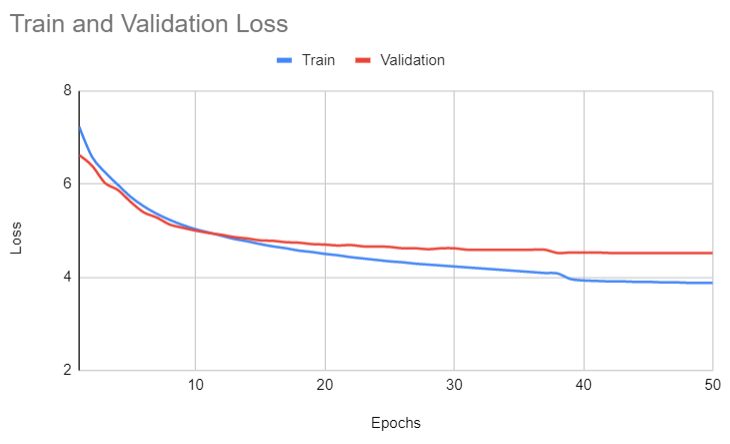

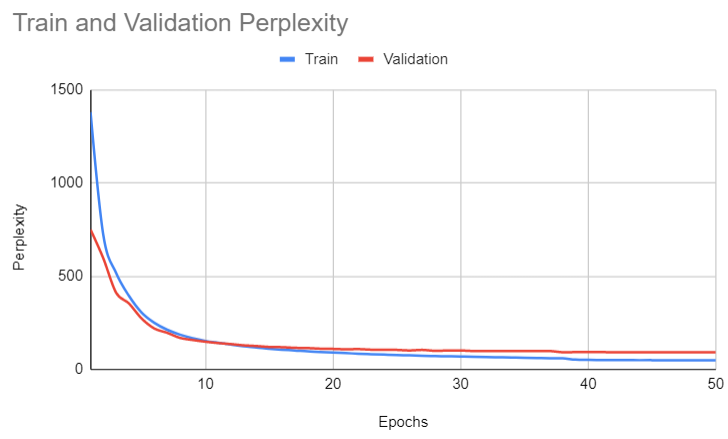

# LSTM + WeigthDrop + Embedded Dropout

To further improve the previous model I tried to add also an implementation of the embedding dropout ([Gal \& Ghahramani, 2016](https://arxiv.org/pdf/1512.05287.pdf)). "*This is equivalent to performing dropout on the embedding matrix at a word level, where the dropout is broadcast across all the word vector's embedding*" ([Merity et al., 2017](https://arxiv.org/pdf/1708.02182.pdf)) 

Code taken from [here](https://github.com/salesforce/awd-lstm-lm/blob/master/embed_regularize.py).

In [49]:
def embedded_dropout(embed, words, dropout=0.1, scale=None):
  if dropout:
    mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - dropout).expand_as(embed.weight) / (1 - dropout)
    masked_embed_weight = mask * embed.weight
  else:
    masked_embed_weight = embed.weight
  if scale:
    masked_embed_weight = scale.expand_as(masked_embed_weight) * masked_embed_weight

  padding_idx = embed.padding_idx
  if padding_idx is None:
      padding_idx = -1

  X = torch.nn.functional.embedding(words, masked_embed_weight,
    padding_idx, embed.max_norm, embed.norm_type,
    embed.scale_grad_by_freq, embed.sparse
  )
  return X

In [50]:
class LSTM_weightDropout_embeddedDropout(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken:int, ninp:int, nhid:int, nlayers:int, dropout:float, wdrop:float, edrop:float):
        super(LSTM_weightDropout_embeddedDropout, self).__init__()
      
        self.dropout = nn.Dropout(dropout)
        self.wdrop = wdrop
        self.edrop = edrop
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = self.rnns = [torch.nn.LSTM(ninp if l == 0 else nhid, nhid if l != nlayers - 1 else nhid, 1, dropout=0) for l in range(nlayers)]
        self.rnns = [WeightDrop(rnn, ['weight_hh_l0'], dropout=wdrop) for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.decoder = nn.Linear(nhid, ntoken)

        if nhid != ninp:
          raise ValueError('When using the tied flag, nhid must be equal to emsize')
          self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.ninp = ninp
        self.nhid = nhid
        self.nlayers = nlayers
        self.ntoken = ntoken

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input:torch.Tensor, hidden:tuple):
        emb = embedded_dropout(self.encoder, input, dropout=self.edrop if self.training else 0)
        emb = self.dropout(emb)
        raw_output = emb
        new_hidden = []

        for l, rnn in enumerate(self.rnns):
            rnn = rnn.to("cuda")
            raw_output, new_h = rnn(raw_output, hidden[l])
            new_hidden.append(new_h)
            
            if l != self.nlayers - 1:
                raw_output = self.dropout(raw_output)
        
        output = self.dropout(raw_output)

        decoded = self.decoder(output)
        decoded = decoded.view(-1, self.ntoken)
        return F.log_softmax(decoded, dim=1), new_hidden

    def init_hidden(self, bsz:int):
        weight = next(self.parameters())
        return [(weight.new_zeros(1, bsz, self.nhid),
                    weight.new_zeros(1, bsz, self.nhid)) for l in range(self.nlayers)]

In [ ]:
dropout = 0.4
wdrop = 0.5
edrop = 0.1
corpus = Corpus(source)
model = LSTM_weightDropout_embeddedDropout(len(corpus.dictionary), emsize, nhid, nlayers, dropout, wdrop, edrop)
main(model, corpus = corpus, initial_lr = 30, model_type = "LSTM_weightDropout_embeddedDropout", optimizer_type = 'SGD', epochs = 50, bptt=bptt, train_bsz = 70, eval_bsz = 10, test_bsz = 1, use_asgd = False, wdecay=wdecay)

Model total parameters: 23165600


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   1 | lr 30.00000 | loss  7.29 | ppl  1466.73
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 42.92s | valid loss  6.91 | valid ppl  1003.17
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   2 | lr 30.00000 | loss  6.60 | ppl   737.11
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 42.03s | valid loss  6.51 | valid ppl   674.94
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   3 | lr 30.00000 | loss  6.33 | ppl   561.02
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 42.44s | valid loss  6.13 | valid ppl   460.35
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   4 | lr 30.00000 | loss  6.08 | ppl   438.71
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 42.59s | valid loss  5.83 | valid ppl   338.73
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   5 | lr 30.00000 | loss  5.87 | ppl   354.68
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 42.43s | valid loss  5.64 | valid ppl   280.81
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   6 | lr 30.00000 | loss  5.70 | ppl   299.82
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 42.39s | valid loss  5.44 | valid ppl   231.43
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   7 | lr 30.00000 | loss  5.55 | ppl   257.21
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 42.50s | valid loss  5.33 | valid ppl   205.49
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   8 | lr 30.00000 | loss  5.45 | ppl   233.11
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 42.48s | valid loss  5.28 | valid ppl   196.02
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   9 | lr 30.00000 | loss  5.35 | ppl   210.00
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 42.60s | valid loss  5.14 | valid ppl   170.57
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  10 | lr 30.00000 | loss  5.27 | ppl   194.23
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 42.83s | valid loss  5.08 | valid ppl   160.24
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  11 | lr 30.00000 | loss  5.20 | ppl   181.68
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 42.77s | valid loss  5.04 | valid ppl   154.50
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  12 | lr 30.00000 | loss  5.14 | ppl   170.41
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 42.81s | valid loss  4.95 | valid ppl   141.68
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  13 | lr 30.00000 | loss  5.08 | ppl   161.44
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 42.73s | valid loss  4.95 | valid ppl   140.62
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  14 | lr 30.00000 | loss  5.02 | ppl   151.79
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 42.80s | valid loss  4.90 | valid ppl   134.55
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  15 | lr 30.00000 | loss  4.96 | ppl   143.28
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 42.90s | valid loss  4.84 | valid ppl   126.52
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  16 | lr 30.00000 | loss  4.93 | ppl   138.23
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 42.79s | valid loss  4.83 | valid ppl   124.76
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  17 | lr 30.00000 | loss  4.89 | ppl   132.89
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 42.65s | valid loss  4.78 | valid ppl   119.36
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  18 | lr 30.00000 | loss  4.85 | ppl   128.25
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 42.76s | valid loss  4.77 | valid ppl   118.46
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  19 | lr 30.00000 | loss  4.81 | ppl   123.34
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 42.82s | valid loss  4.74 | valid ppl   114.96
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  20 | lr 30.00000 | loss  4.78 | ppl   118.64
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 42.86s | valid loss  4.75 | valid ppl   115.13
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  21 | lr 30.00000 | loss  4.75 | ppl   115.50
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 42.95s | valid loss  4.72 | valid ppl   112.41
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  22 | lr 30.00000 | loss  4.73 | ppl   113.13
-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 42.75s | valid loss  4.69 | valid ppl   109.08
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  23 | lr 30.00000 | loss  4.70 | ppl   109.68
-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 42.70s | valid loss  4.69 | valid ppl   108.70
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  24 | lr 30.00000 | loss  4.67 | ppl   106.53
-----------------------------------------------------------------------------------------
| end of epoch  24 | time: 42.66s | valid loss  4.71 | valid ppl   110.92
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  25 | lr 30.00000 | loss  4.65 | ppl   104.16
-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 42.74s | valid loss  4.66 | valid ppl   105.90
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  26 | lr 30.00000 | loss  4.63 | ppl   102.31
-----------------------------------------------------------------------------------------
| end of epoch  26 | time: 42.89s | valid loss  4.65 | valid ppl   104.60
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  27 | lr 30.00000 | loss  4.60 | ppl    99.03
-----------------------------------------------------------------------------------------
| end of epoch  27 | time: 42.78s | valid loss  4.65 | valid ppl   104.12
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  28 | lr 30.00000 | loss  4.58 | ppl    97.42
-----------------------------------------------------------------------------------------
| end of epoch  28 | time: 42.81s | valid loss  4.64 | valid ppl   103.81
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  29 | lr 30.00000 | loss  4.56 | ppl    95.60
-----------------------------------------------------------------------------------------
| end of epoch  29 | time: 42.73s | valid loss  4.65 | valid ppl   104.16
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  30 | lr 30.00000 | loss  4.55 | ppl    94.69
-----------------------------------------------------------------------------------------
| end of epoch  30 | time: 42.98s | valid loss  4.62 | valid ppl   101.58
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  31 | lr 30.00000 | loss  4.52 | ppl    91.79
-----------------------------------------------------------------------------------------
| end of epoch  31 | time: 42.93s | valid loss  4.61 | valid ppl   100.27
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  32 | lr 30.00000 | loss  4.49 | ppl    89.55
-----------------------------------------------------------------------------------------
| end of epoch  32 | time: 42.91s | valid loss  4.64 | valid ppl   103.24
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  33 | lr 30.00000 | loss  4.49 | ppl    88.92
-----------------------------------------------------------------------------------------
| end of epoch  33 | time: 42.99s | valid loss  4.59 | valid ppl    98.45
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  34 | lr 30.00000 | loss  4.46 | ppl    86.68
-----------------------------------------------------------------------------------------
| end of epoch  34 | time: 43.04s | valid loss  4.60 | valid ppl    99.46
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  35 | lr 30.00000 | loss  4.47 | ppl    87.16
-----------------------------------------------------------------------------------------
| end of epoch  35 | time: 42.96s | valid loss  4.59 | valid ppl    98.54
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  36 | lr 30.00000 | loss  4.44 | ppl    85.18
-----------------------------------------------------------------------------------------
| end of epoch  36 | time: 42.91s | valid loss  4.60 | valid ppl    99.42
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  37 | lr 30.00000 | loss  4.42 | ppl    83.43
-----------------------------------------------------------------------------------------
| end of epoch  37 | time: 42.84s | valid loss  4.59 | valid ppl    98.47
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  38 | lr 3.00000 | loss  4.33 | ppl    75.66
-----------------------------------------------------------------------------------------
| end of epoch  38 | time: 42.83s | valid loss  4.53 | valid ppl    92.78
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  39 | lr 3.00000 | loss  4.29 | ppl    72.88
-----------------------------------------------------------------------------------------
| end of epoch  39 | time: 42.89s | valid loss  4.52 | valid ppl    92.28
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  40 | lr 3.00000 | loss  4.27 | ppl    71.74
-----------------------------------------------------------------------------------------
| end of epoch  40 | time: 43.05s | valid loss  4.52 | valid ppl    92.12
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  41 | lr 3.00000 | loss  4.28 | ppl    72.28
-----------------------------------------------------------------------------------------
| end of epoch  41 | time: 43.08s | valid loss  4.52 | valid ppl    91.98
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  42 | lr 3.00000 | loss  4.27 | ppl    71.29
-----------------------------------------------------------------------------------------
| end of epoch  42 | time: 42.95s | valid loss  4.52 | valid ppl    91.76
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  43 | lr 3.00000 | loss  4.27 | ppl    71.68
-----------------------------------------------------------------------------------------
| end of epoch  43 | time: 42.91s | valid loss  4.52 | valid ppl    91.66
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  44 | lr 3.00000 | loss  4.26 | ppl    70.81
-----------------------------------------------------------------------------------------
| end of epoch  44 | time: 42.99s | valid loss  4.52 | valid ppl    91.75
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  45 | lr 3.00000 | loss  4.26 | ppl    70.98
-----------------------------------------------------------------------------------------
| end of epoch  45 | time: 43.07s | valid loss  4.52 | valid ppl    91.67
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  46 | lr 3.00000 | loss  4.24 | ppl    69.75
-----------------------------------------------------------------------------------------
| end of epoch  46 | time: 43.00s | valid loss  4.52 | valid ppl    91.55
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  47 | lr 3.00000 | loss  4.26 | ppl    70.62
-----------------------------------------------------------------------------------------
| end of epoch  47 | time: 43.04s | valid loss  4.52 | valid ppl    91.51
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  48 | lr 3.00000 | loss  4.24 | ppl    69.49
-----------------------------------------------------------------------------------------
| end of epoch  48 | time: 42.94s | valid loss  4.51 | valid ppl    91.33
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  49 | lr 3.00000 | loss  4.25 | ppl    69.87
-----------------------------------------------------------------------------------------
| end of epoch  49 | time: 42.96s | valid loss  4.51 | valid ppl    91.27
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  50 | lr 3.00000 | loss  4.24 | ppl    69.54
-----------------------------------------------------------------------------------------
| end of epoch  50 | time: 42.88s | valid loss  4.51 | valid ppl    91.22
-----------------------------------------------------------------------------------------
Saving model (new best validation)


## Test and comments

The results obtained are very similar to the previous one ($-0.29$), but overfitting is drastically reduced. 

In [64]:
corpus = Corpus(source)
model = LSTM_weightDropout_embeddedDropout(len(corpus.dictionary), emsize, nhid, nlayers, dropout = 0, wdrop = 0, edrop = 0)
main(model, corpus = corpus, model_type = "LSTM_weightDropout_embeddedDropout", test_bsz = 1, test_mode = True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


| End of training | test loss  4.46 | test ppl    86.57


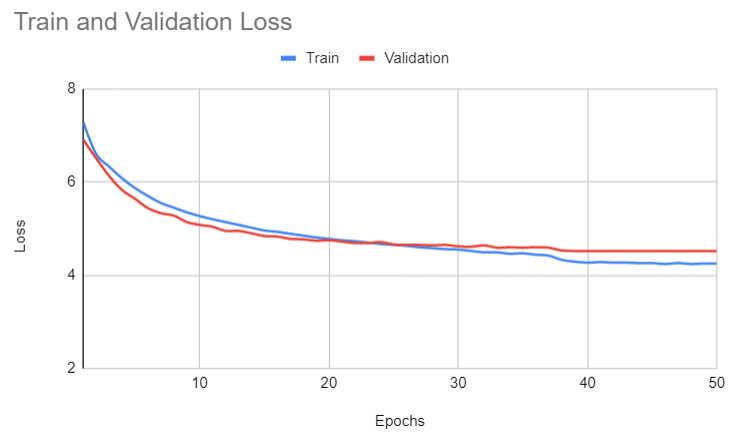

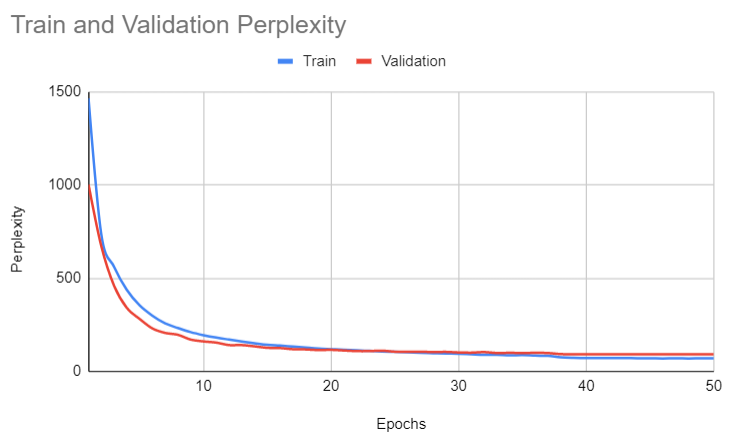

# LSTM + WeigthDrop + Embedded Dropout + Locked Dropout (Variational Dropout)

Continuing to follow what was done by [Merity et al. (2017)](https://arxiv.org/pdf/1708.02182.pdf), Variational Dropout is introduced. Differently from standard dropout where the dropout mask is sampled every time the dropout is called, in Variational Dropout the binary mask is sampled only once during the first call, and then that mask is used for all the repeated connections in the forward and backward pass.

Code taken from [here](https://github.com/salesforce/awd-lstm-lm/blob/master/locked_dropout.py).

In [46]:
class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        if not self.training or not dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

In [51]:
class LSTM_weightDropout_embeddedDropout_lockedDropout(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken:int, ninp:int, nhid:int, nlayers:int, dropout:float, dropouti:float, dropouth:float, wdrop:float, edrop:float):
        super(LSTM_weightDropout_embeddedDropout_lockedDropout, self).__init__()
      
        self.lockdrop = LockedDropout()
        self.wdrop = wdrop
        self.edrop = edrop
        self.idrop = dropouti
        self.hdrop = dropouth
        self.dropout = dropout
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = self.rnns = [torch.nn.LSTM(ninp if l == 0 else nhid, nhid if l != nlayers - 1 else nhid, 1, dropout=0) for l in range(nlayers)]
        self.rnns = [WeightDrop(rnn, ['weight_hh_l0'], dropout=wdrop) for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.decoder = nn.Linear(nhid, ntoken)

        self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.ninp = ninp
        self.nhid = nhid
        self.nlayers = nlayers
        self.ntoken = ntoken

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input:torch.Tensor, hidden:tuple):
        emb = embedded_dropout(self.encoder, input, dropout=self.edrop if self.training else 0)
        emb = self.lockdrop(emb, self.idrop)
        raw_output = emb
        new_hidden = []

        for l, rnn in enumerate(self.rnns):
            rnn = rnn.to("cuda")
            raw_output, new_h = rnn(raw_output, hidden[l])
            new_hidden.append(new_h)
            
            if l != self.nlayers - 1:
                raw_output = self.lockdrop(raw_output, self.hdrop)
        
        output = self.lockdrop(raw_output, self.dropout)

        decoded = self.decoder(output)
        decoded = decoded.view(-1, self.ntoken)
        return F.log_softmax(decoded, dim=1), new_hidden

    def init_hidden(self, bsz:int):
        weight = next(self.parameters())
        return [(weight.new_zeros(1, bsz, self.nhid),
                    weight.new_zeros(1, bsz, self.nhid)) for l in range(self.nlayers)]

In [ ]:
dropout = 0.4
idrop = 0.65
hdrop = 0.3
wdrop = 0.5
edrop = 0.1
corpus = Corpus(source)
model = LSTM_weightDropout_embeddedDropout_lockedDropout(len(corpus.dictionary), emsize, nhid, nlayers, dropout, idrop, hdrop, wdrop, edrop)
main(model, corpus = corpus, initial_lr = 30, model_type = "LSTM_weightDropout_embeddedDropout_lockedDropout", optimizer_type = 'SGD', epochs = 50, bptt=bptt, train_bsz = 70, eval_bsz = 10, test_bsz = 1, use_asgd = False, wdecay=wdecay)

Model total parameters: 16665600


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13277 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


| epoch   1 | lr 30.00000 | loss  7.27 | ppl  1433.69
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 42.33s | valid loss  6.64 | valid ppl   763.50
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   2 | lr 30.00000 | loss  6.63 | ppl   754.47
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 39.11s | valid loss  6.36 | valid ppl   580.97
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   3 | lr 30.00000 | loss  6.38 | ppl   592.77
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 40.66s | valid loss  6.29 | valid ppl   538.30
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   4 | lr 30.00000 | loss  6.07 | ppl   433.73
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 41.32s | valid loss  5.80 | valid ppl   328.84
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   5 | lr 30.00000 | loss  5.82 | ppl   337.77
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 41.32s | valid loss  5.53 | valid ppl   252.44
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   6 | lr 30.00000 | loss  5.63 | ppl   279.37
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 41.33s | valid loss  5.37 | valid ppl   214.34
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   7 | lr 30.00000 | loss  5.50 | ppl   244.58
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 41.32s | valid loss  5.32 | valid ppl   204.46
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   8 | lr 30.00000 | loss  5.40 | ppl   221.23
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 41.31s | valid loss  5.18 | valid ppl   178.14
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   9 | lr 30.00000 | loss  5.31 | ppl   201.97
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 41.35s | valid loss  5.07 | valid ppl   159.19
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  10 | lr 30.00000 | loss  5.22 | ppl   185.65
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 41.40s | valid loss  5.05 | valid ppl   155.91
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  11 | lr 30.00000 | loss  5.17 | ppl   175.53
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 41.39s | valid loss  4.96 | valid ppl   142.19
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  12 | lr 30.00000 | loss  5.11 | ppl   165.52
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 41.30s | valid loss  4.91 | valid ppl   135.34
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  13 | lr 30.00000 | loss  5.06 | ppl   157.32
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 41.33s | valid loss  4.87 | valid ppl   130.20
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  14 | lr 30.00000 | loss  5.01 | ppl   149.25
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 41.32s | valid loss  4.85 | valid ppl   127.68
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  15 | lr 30.00000 | loss  4.96 | ppl   143.19
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 41.32s | valid loss  4.80 | valid ppl   121.43
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  16 | lr 30.00000 | loss  4.92 | ppl   137.19
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 41.36s | valid loss  4.75 | valid ppl   115.83
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  17 | lr 30.00000 | loss  4.88 | ppl   131.66
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 41.41s | valid loss  4.73 | valid ppl   112.95
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  18 | lr 30.00000 | loss  4.85 | ppl   127.15
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 41.37s | valid loss  4.72 | valid ppl   111.62
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  19 | lr 30.00000 | loss  4.81 | ppl   123.34
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 41.34s | valid loss  4.70 | valid ppl   110.22
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  20 | lr 30.00000 | loss  4.78 | ppl   119.32
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 41.33s | valid loss  4.68 | valid ppl   108.31
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  21 | lr 30.00000 | loss  4.76 | ppl   117.10
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 41.34s | valid loss  4.66 | valid ppl   105.84
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  22 | lr 30.00000 | loss  4.72 | ppl   112.13
-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 41.34s | valid loss  4.64 | valid ppl   103.79
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  23 | lr 30.00000 | loss  4.70 | ppl   110.07
-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 41.31s | valid loss  4.65 | valid ppl   104.42
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  24 | lr 30.00000 | loss  4.68 | ppl   107.41
-----------------------------------------------------------------------------------------
| end of epoch  24 | time: 41.39s | valid loss  4.62 | valid ppl   101.42
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  25 | lr 30.00000 | loss  4.64 | ppl   104.05
-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 41.45s | valid loss  4.60 | valid ppl    99.10
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  26 | lr 30.00000 | loss  4.63 | ppl   102.38
-----------------------------------------------------------------------------------------
| end of epoch  26 | time: 41.36s | valid loss  4.58 | valid ppl    97.56
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  27 | lr 30.00000 | loss  4.61 | ppl   100.97
-----------------------------------------------------------------------------------------
| end of epoch  27 | time: 41.33s | valid loss  4.59 | valid ppl    98.03
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  28 | lr 30.00000 | loss  4.59 | ppl    98.44
-----------------------------------------------------------------------------------------
| end of epoch  28 | time: 41.32s | valid loss  4.59 | valid ppl    98.15
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  29 | lr 30.00000 | loss  4.58 | ppl    97.42
-----------------------------------------------------------------------------------------
| end of epoch  29 | time: 41.33s | valid loss  4.56 | valid ppl    95.96
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  30 | lr 30.00000 | loss  4.55 | ppl    94.33
-----------------------------------------------------------------------------------------
| end of epoch  30 | time: 41.33s | valid loss  4.56 | valid ppl    95.36
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  31 | lr 30.00000 | loss  4.54 | ppl    93.47
-----------------------------------------------------------------------------------------
| end of epoch  31 | time: 41.32s | valid loss  4.54 | valid ppl    93.72
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  32 | lr 30.00000 | loss  4.52 | ppl    91.47
-----------------------------------------------------------------------------------------
| end of epoch  32 | time: 41.38s | valid loss  4.53 | valid ppl    93.18
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  33 | lr 30.00000 | loss  4.51 | ppl    91.22
-----------------------------------------------------------------------------------------
| end of epoch  33 | time: 41.39s | valid loss  4.53 | valid ppl    92.31
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  34 | lr 30.00000 | loss  4.49 | ppl    88.78
-----------------------------------------------------------------------------------------
| end of epoch  34 | time: 41.33s | valid loss  4.53 | valid ppl    93.02
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  35 | lr 30.00000 | loss  4.48 | ppl    88.44
-----------------------------------------------------------------------------------------
| end of epoch  35 | time: 41.32s | valid loss  4.51 | valid ppl    91.24
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  36 | lr 30.00000 | loss  4.46 | ppl    86.29
-----------------------------------------------------------------------------------------
| end of epoch  36 | time: 41.30s | valid loss  4.51 | valid ppl    90.65
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  37 | lr 30.00000 | loss  4.45 | ppl    85.84
-----------------------------------------------------------------------------------------
| end of epoch  37 | time: 41.33s | valid loss  4.50 | valid ppl    90.17
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  38 | lr 30.00000 | loss  4.43 | ppl    84.03
-----------------------------------------------------------------------------------------
| end of epoch  38 | time: 41.31s | valid loss  4.53 | valid ppl    92.32
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  39 | lr 30.00000 | loss  4.43 | ppl    83.55
-----------------------------------------------------------------------------------------
| end of epoch  39 | time: 41.36s | valid loss  4.50 | valid ppl    89.86
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  40 | lr 30.00000 | loss  4.40 | ppl    81.71
-----------------------------------------------------------------------------------------
| end of epoch  40 | time: 41.41s | valid loss  4.50 | valid ppl    89.70
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  41 | lr 30.00000 | loss  4.39 | ppl    81.04
-----------------------------------------------------------------------------------------
| end of epoch  41 | time: 41.36s | valid loss  4.50 | valid ppl    89.76
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  42 | lr 30.00000 | loss  4.39 | ppl    80.44
-----------------------------------------------------------------------------------------
| end of epoch  42 | time: 41.36s | valid loss  4.50 | valid ppl    90.02
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  43 | lr 30.00000 | loss  4.38 | ppl    79.61
-----------------------------------------------------------------------------------------
| end of epoch  43 | time: 41.33s | valid loss  4.48 | valid ppl    88.09
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  44 | lr 30.00000 | loss  4.36 | ppl    78.12
-----------------------------------------------------------------------------------------
| end of epoch  44 | time: 41.32s | valid loss  4.47 | valid ppl    87.19
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  45 | lr 30.00000 | loss  4.35 | ppl    77.64
-----------------------------------------------------------------------------------------
| end of epoch  45 | time: 41.35s | valid loss  4.49 | valid ppl    88.87
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  46 | lr 30.00000 | loss  4.34 | ppl    76.49
-----------------------------------------------------------------------------------------
| end of epoch  46 | time: 41.32s | valid loss  4.48 | valid ppl    88.56
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  47 | lr 30.00000 | loss  4.32 | ppl    75.31
-----------------------------------------------------------------------------------------
| end of epoch  47 | time: 41.35s | valid loss  4.47 | valid ppl    87.65
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  48 | lr 30.00000 | loss  4.33 | ppl    75.62
-----------------------------------------------------------------------------------------
| end of epoch  48 | time: 41.35s | valid loss  4.49 | valid ppl    89.44
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  49 | lr 3.00000 | loss  4.25 | ppl    70.19
-----------------------------------------------------------------------------------------
| end of epoch  49 | time: 41.45s | valid loss  4.43 | valid ppl    83.88
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  50 | lr 3.00000 | loss  4.22 | ppl    67.70
-----------------------------------------------------------------------------------------
| end of epoch  50 | time: 41.39s | valid loss  4.43 | valid ppl    83.58
-----------------------------------------------------------------------------------------
Saving model (new best validation)


## Test and comments

The use of variational dropout has helped to drop significantly the final perplexity ($79.66$) and in the mean time to reduce drastically the overfitting.

In [68]:
corpus = Corpus(source)
model = LSTM_weightDropout_embeddedDropout_lockedDropout(len(corpus.dictionary), emsize, nhid, nlayers, dropout = 0, dropouti = 0, dropouth = 0, wdrop = 0, edrop = 0)
main(model, corpus = corpus, model_type = "LSTM_weightDropout_embeddedDropout_lockedDropout", test_bsz = 1, test_mode = True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


| End of training | test loss  4.38 | test ppl    79.66


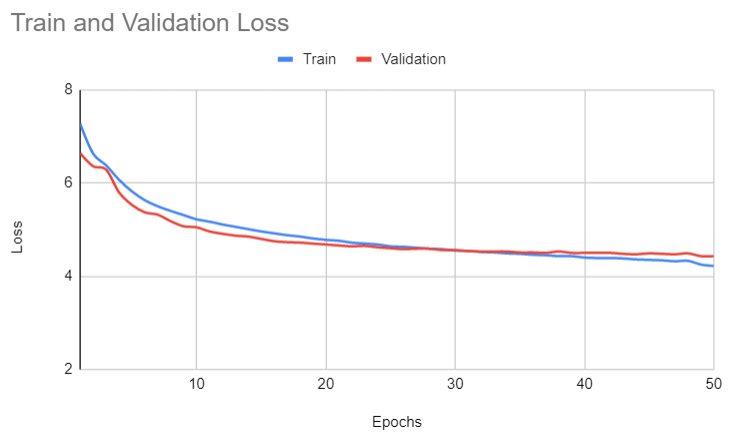

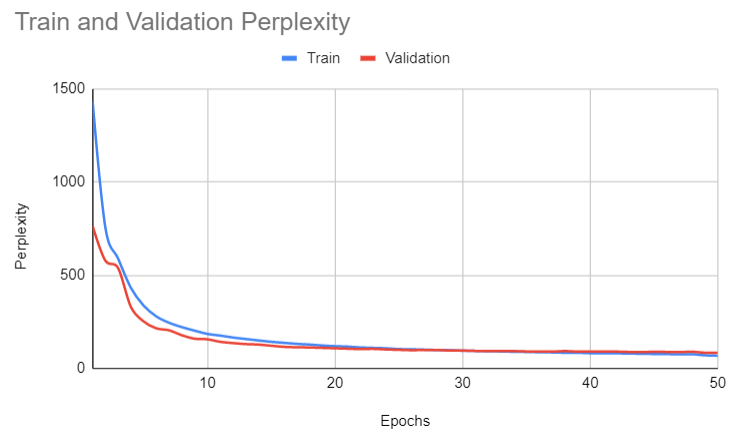

# AWD LSTM

Traditional cross-entropy loss has trouble in handling a large vocabulary size since the softmax operation used results computationally expensive and memory-intensive. To address this issue split cross-entropy loss is introduced. It mitigate the large vocabulary size problems by splitting the vocabulary into two or more partitions and instead of computing the softmax over all the words it is calculated for each partition separately.

Additionally in this model, two regularization techniques have been introduced: Activation Regularization (AR) and Temporal Activation Regularization (TAR) ([Merity et al., 2017](https://arxiv.org/pdf/1708.02182.pdf)).

Code found [here](https://github.com/salesforce/awd-lstm-lm/blob/master/splitcross.py).

In [45]:
class SplitCrossEntropyLoss(nn.Module):
    r'''SplitCrossEntropyLoss calculates an approximate softmax'''
    def __init__(self, hidden_size, splits, verbose=False):
        # We assume splits is [0, split1, split2, N] where N >= |V|
        # For example, a vocab of 1000 words may have splits [0] + [100, 500] + [inf]
        super(SplitCrossEntropyLoss, self).__init__()
        self.hidden_size = hidden_size
        self.splits = [0] + splits + [100 * 1000000]
        self.nsplits = len(self.splits) - 1
        self.stats = defaultdict(list)
        self.verbose = verbose
        # Each of the splits that aren't in the head require a pretend token, we'll call them tombstones
        # The probability given to this tombstone is the probability of selecting an item from the represented split
        if self.nsplits > 1:
            self.tail_vectors = nn.Parameter(torch.zeros(self.nsplits - 1, hidden_size))
            self.tail_bias = nn.Parameter(torch.zeros(self.nsplits - 1))

    def logprob(self, weight, bias, hiddens, splits=None, softmaxed_head_res=None, verbose=False):
        # First we perform the first softmax on the head vocabulary and the tombstones
        if softmaxed_head_res is None:
            start, end = self.splits[0], self.splits[1]
            head_weight = None if end - start == 0 else weight[start:end]
            head_bias = None if end - start == 0 else bias[start:end]
            # We only add the tombstones if we have more than one split
            if self.nsplits > 1:
                head_weight = self.tail_vectors if head_weight is None else torch.cat([head_weight, self.tail_vectors])
                head_bias = self.tail_bias if head_bias is None else torch.cat([head_bias, self.tail_bias])

            # Perform the softmax calculation for the word vectors in the head for all splits
            # We need to guard against empty splits as torch.cat does not like random lists
            head_res = torch.nn.functional.linear(hiddens, head_weight, bias=head_bias)
            softmaxed_head_res = torch.nn.functional.log_softmax(head_res, dim=-1)

        if splits is None:
            splits = list(range(self.nsplits))

        results = []
        running_offset = 0
        for idx in splits:

            # For those targets in the head (idx == 0) we only need to return their loss
            if idx == 0:
                results.append(softmaxed_head_res[:, :-(self.nsplits - 1)])

            # If the target is in one of the splits, the probability is the p(tombstone) * p(word within tombstone)
            else:
                start, end = self.splits[idx], self.splits[idx + 1]
                tail_weight = weight[start:end]
                tail_bias = bias[start:end]

                # Calculate the softmax for the words in the tombstone
                tail_res = torch.nn.functional.linear(hiddens, tail_weight, bias=tail_bias)

                # Then we calculate p(tombstone) * p(word in tombstone)
                # Adding is equivalent to multiplication in log space
                head_entropy = (softmaxed_head_res[:, -idx]).contiguous()
                tail_entropy = torch.nn.functional.log_softmax(tail_res, dim=-1)
                results.append(head_entropy.view(-1, 1) + tail_entropy)

        if len(results) > 1:
            return torch.cat(results, dim=1)
        return results[0]

    def split_on_targets(self, hiddens, targets):
        # Split the targets into those in the head and in the tail
        split_targets = []
        split_hiddens = []

        # Determine to which split each element belongs (for each start split value, add 1 if equal or greater)
        # This method appears slower at least for WT-103 values for approx softmax
        #masks = [(targets >= self.splits[idx]).view(1, -1) for idx in range(1, self.nsplits)]
        #mask = torch.sum(torch.cat(masks, dim=0), dim=0)
        ###
        # This is equally fast for smaller splits as method below but scales linearly
        mask = None
        for idx in range(1, self.nsplits):
            partial_mask = targets >= self.splits[idx]
            mask = mask + partial_mask if mask is not None else partial_mask
        ###
        #masks = torch.stack([targets] * (self.nsplits - 1))
        #mask = torch.sum(masks >= self.split_starts, dim=0)
        for idx in range(self.nsplits):
            # If there are no splits, avoid costly masked select
            if self.nsplits == 1:
                split_targets, split_hiddens = [targets], [hiddens]
                continue
            # If all the words are covered by earlier targets, we have empties so later stages don't freak out
            if sum(len(t) for t in split_targets) == len(targets):
                split_targets.append([])
                split_hiddens.append([])
                continue
            # Are you in our split?
            tmp_mask = mask == idx
            split_targets.append(torch.masked_select(targets, tmp_mask))
            split_hiddens.append(hiddens.masked_select(tmp_mask.unsqueeze(1).expand_as(hiddens)).view(-1, hiddens.size(1)))
        return split_targets, split_hiddens

    def forward(self, weight, bias, hiddens, targets, verbose=False):
        if self.verbose or verbose:
            for idx in sorted(self.stats):
                print('{}: {}'.format(idx, int(np.mean(self.stats[idx]))), end=', ')
            print()

        total_loss = None
        if len(hiddens.size()) > 2: hiddens = hiddens.view(-1, hiddens.size(2))

        split_targets, split_hiddens = self.split_on_targets(hiddens, targets)

        # First we perform the first softmax on the head vocabulary and the tombstones
        start, end = self.splits[0], self.splits[1]
        head_weight = None if end - start == 0 else weight[start:end]
        head_bias = None if end - start == 0 else bias[start:end]

        # We only add the tombstones if we have more than one split
        if self.nsplits > 1:
            head_weight = self.tail_vectors if head_weight is None else torch.cat([head_weight, self.tail_vectors])
            head_bias = self.tail_bias if head_bias is None else torch.cat([head_bias, self.tail_bias])

        # Perform the softmax calculation for the word vectors in the head for all splits
        # We need to guard against empty splits as torch.cat does not like random lists
        combo = torch.cat([split_hiddens[i] for i in range(self.nsplits) if len(split_hiddens[i])])
        ###
        all_head_res = torch.nn.functional.linear(combo, head_weight, bias=head_bias)
        softmaxed_all_head_res = torch.nn.functional.log_softmax(all_head_res, dim=-1)
        if self.verbose or verbose:
            self.stats[0].append(combo.size()[0] * head_weight.size()[0])

        running_offset = 0
        for idx in range(self.nsplits):
            # If there are no targets for this split, continue
            if len(split_targets[idx]) == 0: continue

            # For those targets in the head (idx == 0) we only need to return their loss
            if idx == 0:
                softmaxed_head_res = softmaxed_all_head_res[running_offset:running_offset + len(split_hiddens[idx])]
                entropy = -torch.gather(softmaxed_head_res, dim=1, index=split_targets[idx].view(-1, 1))
            # If the target is in one of the splits, the probability is the p(tombstone) * p(word within tombstone)
            else:
                softmaxed_head_res = softmaxed_all_head_res[running_offset:running_offset + len(split_hiddens[idx])]

                if self.verbose or verbose:
                    start, end = self.splits[idx], self.splits[idx + 1]
                    tail_weight = weight[start:end]
                    self.stats[idx].append(split_hiddens[idx].size()[0] * tail_weight.size()[0])

                # Calculate the softmax for the words in the tombstone
                tail_res = self.logprob(weight, bias, split_hiddens[idx], splits=[idx], softmaxed_head_res=softmaxed_head_res)

                # Then we calculate p(tombstone) * p(word in tombstone)
                # Adding is equivalent to multiplication in log space
                head_entropy = softmaxed_head_res[:, -idx]
                # All indices are shifted - if the first split handles [0,...,499] then the 500th in the second split will be 0 indexed
                indices = (split_targets[idx] - self.splits[idx]).view(-1, 1)
                # Warning: if you don't squeeze, you get an N x 1 return, which acts oddly with broadcasting
                tail_entropy = torch.gather(torch.nn.functional.log_softmax(tail_res, dim=-1), dim=1, index=indices).squeeze()
                entropy = -(head_entropy + tail_entropy)
            ###
            running_offset += len(split_hiddens[idx])
            total_loss = entropy.float().sum() if total_loss is None else total_loss + entropy.float().sum()

        return (total_loss / len(targets)).type_as(weight)

In [52]:
class AWS_LSTM(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken:int, ninp:int, nhid:int, nlayers:int, dropout:float, dropouth:float, dropouti:float, dropoute:float, wdrop:float):
        super(AWS_LSTM, self).__init__()

        self.lockdrop = LockedDropout()
        self.idrop = dropouti
        self.hdrop = dropouth
        self.edrop = dropoute
        self.wdrop = wdrop
        self.dropout = dropout

        self.encoder = nn.Embedding(ntoken, ninp)

        
        self.rnns = [torch.nn.LSTM(ninp if l == 0 else nhid, nhid if l != nlayers - 1 else nhid, 1, dropout=0)\
                    for l in range(nlayers)]          
        self.rnns = [WeightDrop(rnn, ['weight_hh_l0'], dropout=wdrop) for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.decoder = nn.Linear(nhid, ntoken)

        self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.ninp = ninp
        self.nhid = nhid
        self.nlayers = nlayers
        self.ntoken = ntoken

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input:torch.Tensor, hidden:tuple, return_h:bool=False):

        emb = embedded_dropout(self.encoder, input, dropout=self.edrop if self.training else 0)
        emb = self.lockdrop(emb, self.idrop)

        raw_output = emb
        new_hidden = []
        raw_outputs = []
        outputs = []

        for l, rnn in enumerate(self.rnns):
            current_input = raw_output
            raw_output, new_h = rnn(raw_output, hidden[l])
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)

            if l != self.nlayers - 1:
                raw_output = self.lockdrop(raw_output, self.hdrop)
                outputs.append(raw_output)

        hidden = new_hidden
        output = self.lockdrop(raw_output, self.dropout)
        outputs.append(output)
        
        result = output.view(output.size(0)*output.size(1), output.size(2))

        if return_h:
            return result, hidden, raw_outputs, outputs
        return result, hidden

    def init_hidden(self, bsz:int):
        weight = next(self.parameters()).data
        return [(weight.new(1, bsz, self.nhid if l != self.nlayers - 1 else self.nhid).zero_(),
                weight.new(1, bsz, self.nhid if l != self.nlayers - 1 else self.nhid).zero_())
                for l in range(self.nlayers)]

In [ ]:
dropout = 0.4
idrop = 0.65
hdrop = 0.3
wdrop = 0.5
edrop = 0.1
alpha = 2
beta = 1
splits = []
criterion = SplitCrossEntropyLoss(emsize, splits=splits, verbose=False)
corpus = Corpus(source)
model = AWS_LSTM(len(corpus.dictionary), emsize, nhid, nlayers, dropout, hdrop, idrop, edrop, wdrop)
main(model, corpus = corpus, initial_lr = 30, model_type = "AWS_LSTM", optimizer_type = 'SGD', criterion = criterion, \
     epochs = 50, bptt=bptt, train_bsz = 70, eval_bsz = 10, test_bsz = 1, use_asgd = False, AWS = True, alpha = alpha, beta = beta, wdecay = wdecay)

Model total parameters: 16665600


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   1 | lr 30.00000 | loss  7.23 | ppl  1381.97
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 40.94s | valid loss  6.69 | valid ppl   802.84
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   2 | lr 30.00000 | loss  6.61 | ppl   744.16
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 41.14s | valid loss  6.66 | valid ppl   778.60
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   3 | lr 30.00000 | loss  6.37 | ppl   582.73
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 41.19s | valid loss  6.18 | valid ppl   485.40
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   4 | lr 30.00000 | loss  6.09 | ppl   439.35
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 41.21s | valid loss  5.86 | valid ppl   350.64
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   5 | lr 30.00000 | loss  5.87 | ppl   352.93
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 41.24s | valid loss  5.61 | valid ppl   272.75
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   6 | lr 30.00000 | loss  5.70 | ppl   298.21
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 41.30s | valid loss  5.44 | valid ppl   229.74
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   7 | lr 30.00000 | loss  5.57 | ppl   262.71
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 41.25s | valid loss  5.33 | valid ppl   206.41
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   8 | lr 30.00000 | loss  5.47 | ppl   238.28
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 41.26s | valid loss  5.19 | valid ppl   178.94
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   9 | lr 30.00000 | loss  5.39 | ppl   219.24
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 41.20s | valid loss  5.11 | valid ppl   166.27
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  10 | lr 30.00000 | loss  5.31 | ppl   203.00
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 41.23s | valid loss  5.07 | valid ppl   158.93
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  11 | lr 30.00000 | loss  5.26 | ppl   192.56
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 41.23s | valid loss  5.00 | valid ppl   148.53
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  12 | lr 30.00000 | loss  5.21 | ppl   182.51
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 41.23s | valid loss  4.93 | valid ppl   138.98
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  13 | lr 30.00000 | loss  5.16 | ppl   173.47
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 41.21s | valid loss  4.89 | valid ppl   133.10
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  14 | lr 30.00000 | loss  5.11 | ppl   165.92
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 41.21s | valid loss  4.86 | valid ppl   128.67
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  15 | lr 30.00000 | loss  5.07 | ppl   159.31
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 41.32s | valid loss  4.82 | valid ppl   123.65
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  16 | lr 30.00000 | loss  5.03 | ppl   152.77
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 41.24s | valid loss  4.78 | valid ppl   119.61
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  17 | lr 30.00000 | loss  4.99 | ppl   147.13
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 41.27s | valid loss  4.76 | valid ppl   116.92
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  18 | lr 30.00000 | loss  4.96 | ppl   141.94
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 41.23s | valid loss  4.73 | valid ppl   112.94
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  19 | lr 30.00000 | loss  4.93 | ppl   138.01
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 41.24s | valid loss  4.71 | valid ppl   111.19
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  20 | lr 30.00000 | loss  4.90 | ppl   134.63
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 41.22s | valid loss  4.67 | valid ppl   107.17
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  21 | lr 30.00000 | loss  4.88 | ppl   131.22
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 41.23s | valid loss  4.66 | valid ppl   106.00
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  22 | lr 30.00000 | loss  4.84 | ppl   126.25
-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 41.22s | valid loss  4.65 | valid ppl   104.90
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  23 | lr 30.00000 | loss  4.82 | ppl   124.02
-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 41.30s | valid loss  4.63 | valid ppl   102.61
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  24 | lr 30.00000 | loss  4.79 | ppl   120.82
-----------------------------------------------------------------------------------------
| end of epoch  24 | time: 41.26s | valid loss  4.60 | valid ppl    99.82
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  25 | lr 30.00000 | loss  4.76 | ppl   117.29
-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 41.23s | valid loss  4.60 | valid ppl    99.07
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  26 | lr 30.00000 | loss  4.75 | ppl   115.13
-----------------------------------------------------------------------------------------
| end of epoch  26 | time: 41.23s | valid loss  4.58 | valid ppl    97.19
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  27 | lr 30.00000 | loss  4.74 | ppl   113.95
-----------------------------------------------------------------------------------------
| end of epoch  27 | time: 41.21s | valid loss  4.56 | valid ppl    95.98
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  28 | lr 30.00000 | loss  4.71 | ppl   111.49
-----------------------------------------------------------------------------------------
| end of epoch  28 | time: 41.25s | valid loss  4.55 | valid ppl    94.46
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  29 | lr 30.00000 | loss  4.70 | ppl   109.66
-----------------------------------------------------------------------------------------
| end of epoch  29 | time: 41.20s | valid loss  4.54 | valid ppl    93.98
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  30 | lr 30.00000 | loss  4.67 | ppl   106.47
-----------------------------------------------------------------------------------------
| end of epoch  30 | time: 41.19s | valid loss  4.53 | valid ppl    92.41
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  31 | lr 30.00000 | loss  4.66 | ppl   105.47
-----------------------------------------------------------------------------------------
| end of epoch  31 | time: 41.26s | valid loss  4.51 | valid ppl    90.97
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  32 | lr 30.00000 | loss  4.64 | ppl   103.33
-----------------------------------------------------------------------------------------
| end of epoch  32 | time: 41.30s | valid loss  4.51 | valid ppl    90.61
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  33 | lr 30.00000 | loss  4.63 | ppl   103.00
-----------------------------------------------------------------------------------------
| end of epoch  33 | time: 41.26s | valid loss  4.50 | valid ppl    89.69
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  34 | lr 30.00000 | loss  4.61 | ppl   100.72
-----------------------------------------------------------------------------------------
| end of epoch  34 | time: 41.25s | valid loss  4.49 | valid ppl    88.72
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  35 | lr 30.00000 | loss  4.61 | ppl   100.10
-----------------------------------------------------------------------------------------
| end of epoch  35 | time: 41.24s | valid loss  4.48 | valid ppl    88.52
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  36 | lr 30.00000 | loss  4.58 | ppl    97.93
-----------------------------------------------------------------------------------------
| end of epoch  36 | time: 41.26s | valid loss  4.47 | valid ppl    87.28
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  37 | lr 30.00000 | loss  4.58 | ppl    97.25
-----------------------------------------------------------------------------------------
| end of epoch  37 | time: 41.25s | valid loss  4.46 | valid ppl    86.91
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  38 | lr 30.00000 | loss  4.55 | ppl    95.07
-----------------------------------------------------------------------------------------
| end of epoch  38 | time: 41.25s | valid loss  4.46 | valid ppl    86.58
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  39 | lr 30.00000 | loss  4.55 | ppl    94.81
-----------------------------------------------------------------------------------------
| end of epoch  39 | time: 41.23s | valid loss  4.46 | valid ppl    86.45
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  40 | lr 30.00000 | loss  4.53 | ppl    92.91
-----------------------------------------------------------------------------------------
| end of epoch  40 | time: 41.27s | valid loss  4.47 | valid ppl    87.61
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  41 | lr 30.00000 | loss  4.52 | ppl    91.93
-----------------------------------------------------------------------------------------
| end of epoch  41 | time: 41.28s | valid loss  4.45 | valid ppl    85.32
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  42 | lr 30.00000 | loss  4.51 | ppl    91.36
-----------------------------------------------------------------------------------------
| end of epoch  42 | time: 41.28s | valid loss  4.43 | valid ppl    84.23
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  43 | lr 30.00000 | loss  4.50 | ppl    90.22
-----------------------------------------------------------------------------------------
| end of epoch  43 | time: 41.23s | valid loss  4.43 | valid ppl    83.92
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  44 | lr 30.00000 | loss  4.49 | ppl    88.90
-----------------------------------------------------------------------------------------
| end of epoch  44 | time: 41.26s | valid loss  4.42 | valid ppl    82.95
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  45 | lr 30.00000 | loss  4.48 | ppl    88.24
-----------------------------------------------------------------------------------------
| end of epoch  45 | time: 41.23s | valid loss  4.42 | valid ppl    82.94
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  46 | lr 30.00000 | loss  4.47 | ppl    86.99
-----------------------------------------------------------------------------------------
| end of epoch  46 | time: 41.23s | valid loss  4.41 | valid ppl    82.32
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  47 | lr 30.00000 | loss  4.45 | ppl    85.92
-----------------------------------------------------------------------------------------
| end of epoch  47 | time: 41.23s | valid loss  4.42 | valid ppl    82.83
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  48 | lr 30.00000 | loss  4.46 | ppl    86.07
-----------------------------------------------------------------------------------------
| end of epoch  48 | time: 41.25s | valid loss  4.41 | valid ppl    82.25
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  49 | lr 30.00000 | loss  4.45 | ppl    85.65
-----------------------------------------------------------------------------------------
| end of epoch  49 | time: 41.29s | valid loss  4.41 | valid ppl    82.09
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  50 | lr 30.00000 | loss  4.43 | ppl    83.56
-----------------------------------------------------------------------------------------
| end of epoch  50 | time: 41.33s | valid loss  4.40 | valid ppl    81.28
-----------------------------------------------------------------------------------------
Saving model (new best validation)


## Test and comments

This model shows a better result compared to the previous ones both in terms of perplexity and overfitting.

In [71]:
corpus = Corpus(source)
model = AWS_LSTM(len(corpus.dictionary), emsize, nhid, nlayers, dropout = 0, dropouth = 0, dropouti = 0, dropoute = 0, wdrop = 0)
main(model, corpus = corpus, model_type = "AWS_LSTM", test_bsz = 1, AWS = True, test_mode = True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


| End of training | test loss  4.36 | test ppl    77.98


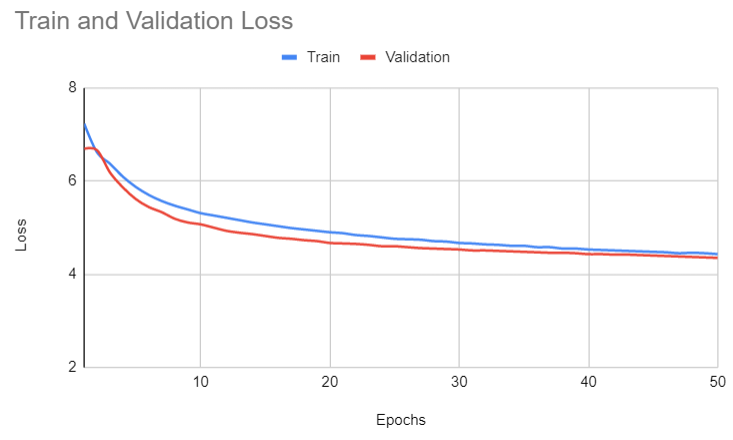

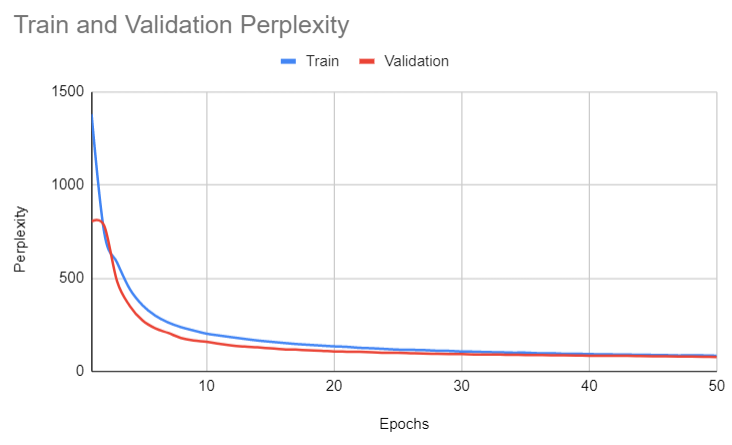

# Mogrifier AWD LSTM

As final addition, I tried to implement the idea of [Melis et al. (2020)](https://arxiv.org/pdf/1909.01792.pdf) which proposed the Mogrifier LSTM. The concept behind this implementation is to modulate the input and the hidden state of the LSTM before feeding them into the LSTM layer. The image below shows the idea of the paper.

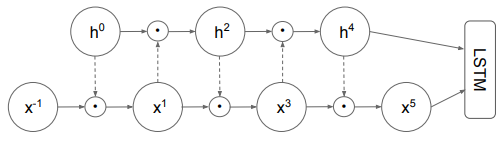

In [53]:
def mogrify(x, states, mogrifier_list):
  h, c = states
  for i in range(5):
    if (i+1) % 2 == 0: 
      h = (2*torch.sigmoid(mogrifier_list[i](x))) * h
    else:
      x = (2*torch.sigmoid(mogrifier_list[i](h))) * x
  return x, (torch.mean(h, 0, True), c)

In [54]:
class AWS_LSTM_Mogrify(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken:int, ninp:int, nhid:int, nlayers:int, dropout:float, dropouth:float, dropouti:float, dropoute:float, wdrop:float, msteps:int):
        super(AWS_LSTM_Mogrify, self).__init__()

        self.lockdrop = LockedDropout()
        self.dropout = dropout
        self.idrop = dropouti
        self.hdrop = dropouth
        self.edrop = dropoute
        self.wdrop = wdrop

        self.encoder = nn.Embedding(ntoken, ninp)
        
        self.rnns = [torch.nn.LSTM(ninp if l == 0 else nhid, nhid if l != nlayers - 1 else nhid, 1, dropout=0)\
                         for l in range(nlayers)]
        self.mogrifier_list = nn.ModuleList([nn.Linear(nhid, ninp)])  # start with q
        for i in range(1, msteps):
          if i % 2 == 0:
            self.mogrifier_list.extend([nn.Linear(nhid, ninp)])  # q
          else:
            self.mogrifier_list.extend([nn.Linear(ninp, nhid)])  # r
            
        self.rnns = [WeightDrop(rnn, ['weight_hh_l0'], dropout=wdrop) for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.decoder = nn.Linear(nhid, ntoken)

        self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.ninp = ninp
        self.nhid = nhid
        self.nlayers = nlayers
        self.ntoken = ntoken

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input:torch.Tensor, hidden:tuple, return_h:bool=False):
        emb = embedded_dropout(self.encoder, input, dropout=self.edrop if self.training else 0)
        emb = self.lockdrop(emb, self.idrop)

        raw_output = emb
        new_hidden = []
        raw_outputs = []
        outputs = []

        for l, rnn in enumerate(self.rnns):
            current_input = raw_output

            raw_output, new_h = mogrify(raw_output, hidden[l], self.mogrifier_list)
            raw_output, new_h = rnn(raw_output, new_h)

            new_hidden.append(new_h)
            raw_outputs.append(raw_output)

            if l != self.nlayers - 1:
                raw_output = self.lockdrop(raw_output, self.hdrop)
                outputs.append(raw_output)

        hidden = new_hidden

        output = self.lockdrop(raw_output, self.dropout)
        outputs.append(output)

        result = output.view(output.size(0)*output.size(1), output.size(2))

        if return_h:
            return result, hidden, raw_outputs, outputs
        return result, hidden

    def init_hidden(self, bsz:int):
        weight = next(self.parameters()).data
        return [(weight.new(1, bsz, self.nhid if l != self.nlayers - 1 else self.nhid).zero_(),
                weight.new(1, bsz, self.nhid if l != self.nlayers - 1 else self.nhid).zero_())
                for l in range(self.nlayers)]

In [ ]:
idrop = 0.65
hdrop = 0.3
wdrop = 0.5
edrop = 0.1
dropout = 0.4
alpha = 2
beta = 1
splits = []
criterion = SplitCrossEntropyLoss(emsize, splits=splits, verbose=False)
mogrify_steps = 5
corpus = Corpus(source)
model = AWS_LSTM_Mogrify(len(corpus.dictionary), emsize, nhid, nlayers, dropout, hdrop, idrop, edrop, wdrop, mogrify_steps)
main(model, corpus = corpus, initial_lr = 30, model_type = "Mogrifier_AWD_LSTM", optimizer_type = 'SGD', criterion = criterion, \
     epochs = 50, bptt=bptt, train_bsz = 70, eval_bsz = 10, test_bsz = 1, use_asgd = False, AWS = True, alpha = alpha, beta = beta, wdecay=wdecay)

Model total parameters: 18781350


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13277 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


| epoch   1 | lr 30.00000 | loss  7.21 | ppl  1349.72
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 53.11s | valid loss  6.69 | valid ppl   804.93
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   2 | lr 30.00000 | loss  6.65 | ppl   769.66
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 51.24s | valid loss  6.51 | valid ppl   671.77
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   3 | lr 30.00000 | loss  6.43 | ppl   620.79
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 52.33s | valid loss  6.20 | valid ppl   490.42
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   4 | lr 30.00000 | loss  6.09 | ppl   441.95
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 52.63s | valid loss  5.80 | valid ppl   330.69
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   5 | lr 30.00000 | loss  5.83 | ppl   339.50
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 53.02s | valid loss  5.47 | valid ppl   238.07
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   6 | lr 30.00000 | loss  5.62 | ppl   276.85
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 52.49s | valid loss  5.33 | valid ppl   207.03
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   7 | lr 30.00000 | loss  5.49 | ppl   241.64
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 52.26s | valid loss  5.20 | valid ppl   180.51
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   8 | lr 30.00000 | loss  5.38 | ppl   216.47
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 52.28s | valid loss  5.08 | valid ppl   160.71
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   9 | lr 30.00000 | loss  5.28 | ppl   196.25
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 52.18s | valid loss  4.99 | valid ppl   146.43
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  10 | lr 30.00000 | loss  5.20 | ppl   181.05
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 52.21s | valid loss  4.94 | valid ppl   139.43
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  11 | lr 30.00000 | loss  5.14 | ppl   170.30
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 52.68s | valid loss  4.86 | valid ppl   129.53
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  12 | lr 30.00000 | loss  5.08 | ppl   161.14
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 52.99s | valid loss  4.80 | valid ppl   122.07
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  13 | lr 30.00000 | loss  5.03 | ppl   152.78
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 52.63s | valid loss  4.76 | valid ppl   116.74
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  14 | lr 30.00000 | loss  4.98 | ppl   146.18
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 52.34s | valid loss  4.74 | valid ppl   114.11
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  15 | lr 30.00000 | loss  4.95 | ppl   140.57
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 52.25s | valid loss  4.70 | valid ppl   110.04
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  16 | lr 30.00000 | loss  4.91 | ppl   135.08
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 52.34s | valid loss  4.68 | valid ppl   107.45
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  17 | lr 30.00000 | loss  4.87 | ppl   130.09
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 52.20s | valid loss  4.65 | valid ppl   104.78
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  18 | lr 30.00000 | loss  4.84 | ppl   125.86
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 52.31s | valid loss  4.63 | valid ppl   102.04
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  19 | lr 30.00000 | loss  4.81 | ppl   122.73
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 52.63s | valid loss  4.61 | valid ppl   100.19
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  20 | lr 30.00000 | loss  4.78 | ppl   119.55
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 52.94s | valid loss  4.59 | valid ppl    98.22
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  21 | lr 30.00000 | loss  4.77 | ppl   117.46
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 52.64s | valid loss  4.57 | valid ppl    96.74
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  22 | lr 30.00000 | loss  4.72 | ppl   112.71
-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 52.21s | valid loss  4.56 | valid ppl    96.06
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  23 | lr 30.00000 | loss  4.71 | ppl   111.07
-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 52.26s | valid loss  4.54 | valid ppl    93.77
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  24 | lr 30.00000 | loss  4.69 | ppl   108.59
-----------------------------------------------------------------------------------------
| end of epoch  24 | time: 52.16s | valid loss  4.52 | valid ppl    92.07
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  25 | lr 30.00000 | loss  4.66 | ppl   105.36
-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 52.20s | valid loss  4.52 | valid ppl    92.01
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  26 | lr 30.00000 | loss  4.64 | ppl   103.53
-----------------------------------------------------------------------------------------
| end of epoch  26 | time: 52.44s | valid loss  4.51 | valid ppl    90.69
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  27 | lr 30.00000 | loss  4.63 | ppl   102.88
-----------------------------------------------------------------------------------------
| end of epoch  27 | time: 52.93s | valid loss  4.49 | valid ppl    89.49
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  28 | lr 30.00000 | loss  4.61 | ppl   100.34
-----------------------------------------------------------------------------------------
| end of epoch  28 | time: 53.02s | valid loss  4.48 | valid ppl    88.65
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  29 | lr 30.00000 | loss  4.59 | ppl    98.83
-----------------------------------------------------------------------------------------
| end of epoch  29 | time: 52.58s | valid loss  4.47 | valid ppl    87.54
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  30 | lr 30.00000 | loss  4.57 | ppl    96.38
-----------------------------------------------------------------------------------------
| end of epoch  30 | time: 52.21s | valid loss  4.47 | valid ppl    87.02
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  31 | lr 30.00000 | loss  4.56 | ppl    95.55
-----------------------------------------------------------------------------------------
| end of epoch  31 | time: 52.22s | valid loss  4.45 | valid ppl    86.04
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  32 | lr 30.00000 | loss  4.54 | ppl    93.53
-----------------------------------------------------------------------------------------
| end of epoch  32 | time: 52.29s | valid loss  4.45 | valid ppl    85.59
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  33 | lr 30.00000 | loss  4.54 | ppl    93.59
-----------------------------------------------------------------------------------------
| end of epoch  33 | time: 52.24s | valid loss  4.45 | valid ppl    85.84
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  34 | lr 30.00000 | loss  4.52 | ppl    91.56
-----------------------------------------------------------------------------------------
| end of epoch  34 | time: 52.47s | valid loss  4.45 | valid ppl    85.79
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  35 | lr 30.00000 | loss  4.51 | ppl    91.08
-----------------------------------------------------------------------------------------
| end of epoch  35 | time: 53.02s | valid loss  4.44 | valid ppl    84.65
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  36 | lr 30.00000 | loss  4.49 | ppl    88.94
-----------------------------------------------------------------------------------------
| end of epoch  36 | time: 52.84s | valid loss  4.42 | valid ppl    83.46
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  37 | lr 30.00000 | loss  4.48 | ppl    88.41
-----------------------------------------------------------------------------------------
| end of epoch  37 | time: 52.49s | valid loss  4.43 | valid ppl    84.03
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  38 | lr 30.00000 | loss  4.46 | ppl    86.73
-----------------------------------------------------------------------------------------
| end of epoch  38 | time: 52.27s | valid loss  4.42 | valid ppl    83.36
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  39 | lr 30.00000 | loss  4.46 | ppl    86.75
-----------------------------------------------------------------------------------------
| end of epoch  39 | time: 52.34s | valid loss  4.42 | valid ppl    82.82
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  40 | lr 30.00000 | loss  4.44 | ppl    84.85
-----------------------------------------------------------------------------------------
| end of epoch  40 | time: 52.43s | valid loss  4.42 | valid ppl    83.50
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  41 | lr 30.00000 | loss  4.43 | ppl    83.91
-----------------------------------------------------------------------------------------
| end of epoch  41 | time: 52.80s | valid loss  4.40 | valid ppl    81.85
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  42 | lr 30.00000 | loss  4.43 | ppl    83.66
-----------------------------------------------------------------------------------------
| end of epoch  42 | time: 53.02s | valid loss  4.40 | valid ppl    81.48
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  43 | lr 30.00000 | loss  4.41 | ppl    82.63
-----------------------------------------------------------------------------------------
| end of epoch  43 | time: 52.71s | valid loss  4.40 | valid ppl    81.39
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  44 | lr 30.00000 | loss  4.40 | ppl    81.45
-----------------------------------------------------------------------------------------
| end of epoch  44 | time: 52.21s | valid loss  4.39 | valid ppl    80.67
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  45 | lr 30.00000 | loss  4.40 | ppl    81.05
-----------------------------------------------------------------------------------------
| end of epoch  45 | time: 52.26s | valid loss  4.39 | valid ppl    80.48
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  46 | lr 30.00000 | loss  4.38 | ppl    79.93
-----------------------------------------------------------------------------------------
| end of epoch  46 | time: 52.23s | valid loss  4.38 | valid ppl    80.12
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  47 | lr 30.00000 | loss  4.37 | ppl    78.97
-----------------------------------------------------------------------------------------
| end of epoch  47 | time: 52.36s | valid loss  4.39 | valid ppl    80.48
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  48 | lr 30.00000 | loss  4.37 | ppl    79.20
-----------------------------------------------------------------------------------------
| end of epoch  48 | time: 52.78s | valid loss  4.38 | valid ppl    80.03
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  49 | lr 30.00000 | loss  4.37 | ppl    79.01
-----------------------------------------------------------------------------------------
| end of epoch  49 | time: 53.30s | valid loss  4.38 | valid ppl    80.22
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  50 | lr 30.00000 | loss  4.34 | ppl    76.84
-----------------------------------------------------------------------------------------
| end of epoch  50 | time: 52.83s | valid loss  4.38 | valid ppl    79.47
-----------------------------------------------------------------------------------------
Saving model (new best validation)


## Test and comments

The mogrifier AWS LSTM results to be the best model implemented, but the sensation is that 50 epochs are not enough to get the best out of this model. In order to get the best possible model in the next section different parameters and a higher number of epochs will be tried to see if the performances can still improve.

In [75]:
mogrify_steps = 5
corpus = Corpus(source)
model = AWS_LSTM_Mogrify(len(corpus.dictionary), emsize, nhid, nlayers, dropout = 0, dropouth = 0, dropouti = 0, dropoute = 0, wdrop = 0, msteps = mogrify_steps)
main(model, corpus = corpus, model_type = "Mogrifier_AWS_LSTM", test_bsz = 1, AWS = True, test_mode = True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


| End of training | test loss  4.33 | test ppl    76.24


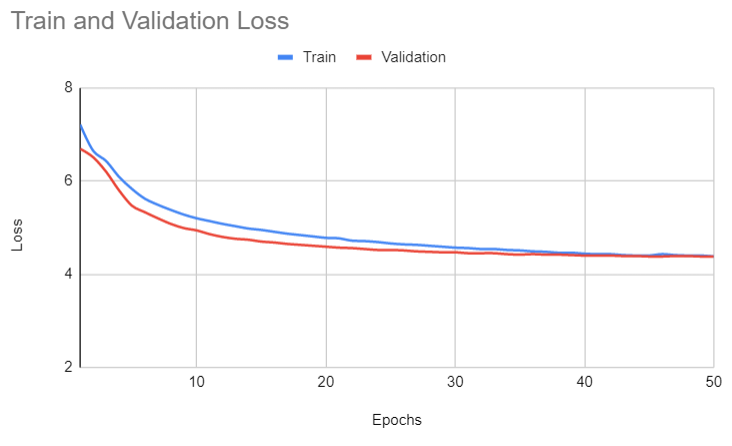

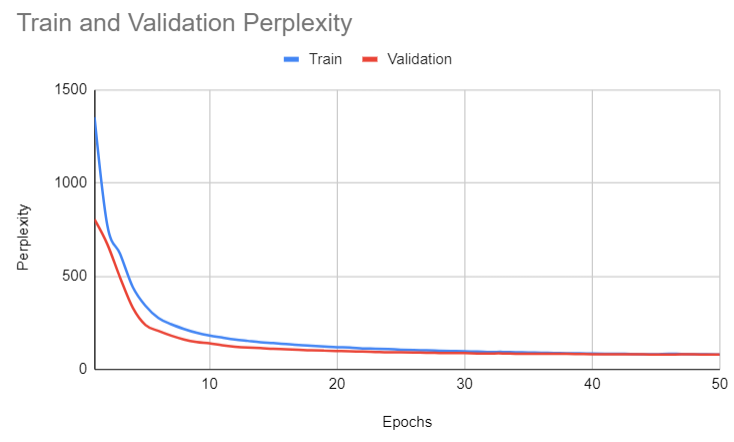

#  Mogrify AWD LSTM (1150 embedding size + 1150 hidden size)

The first attempt is done by using an embedding size and a hidden size of 1150. The idea is that using a larger size for both of these parameters should improve the final perplexity.

In [ ]:
idrop = 0.65
hdrop = 0.3
wdrop = 0.5
edrop = 0.1
dropout = 0.4
alpha = 2
beta = 1
splits = []
criterion = SplitCrossEntropyLoss(emsize, splits=splits, verbose=False)
mogrify_steps = 5
corpus = Corpus(source)
model = AWS_LSTM_Mogrify(len(corpus.dictionary), 1150, 1150, 3, dropout, hdrop, idrop, edrop, wdrop, mogrify_steps)
main(model, corpus = corpus, initial_lr = 30, model_type = "Mogrifier_AWS_LSTM_upgrade", optimizer_type = 'SGD', criterion = criterion, \
     epochs = 100, bptt=bptt, train_bsz = 70, eval_bsz = 10, test_bsz = 1, use_asgd = False, AWS = True, alpha = alpha, beta = beta, wdecay=wdecay)

Model total parameters: 49895850


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   1 | lr 30.00000 | loss  7.42 | ppl  1674.52
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 115.21s | valid loss  6.66 | valid ppl   776.80
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   2 | lr 30.00000 | loss  6.67 | ppl   787.41
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 114.92s | valid loss  6.61 | valid ppl   742.33
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   3 | lr 30.00000 | loss  6.51 | ppl   672.67
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 114.92s | valid loss  6.29 | valid ppl   539.55
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   4 | lr 30.00000 | loss  6.19 | ppl   489.86
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 115.22s | valid loss  5.95 | valid ppl   383.85
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   5 | lr 30.00000 | loss  5.86 | ppl   350.58
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 115.15s | valid loss  5.54 | valid ppl   253.72
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   6 | lr 30.00000 | loss  5.62 | ppl   274.54
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 115.22s | valid loss  5.30 | valid ppl   199.40
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   7 | lr 30.00000 | loss  5.45 | ppl   233.34
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 115.22s | valid loss  5.24 | valid ppl   188.96
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   8 | lr 30.00000 | loss  5.30 | ppl   201.20
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 115.46s | valid loss  5.02 | valid ppl   151.23
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   9 | lr 30.00000 | loss  5.18 | ppl   178.22
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 115.40s | valid loss  4.94 | valid ppl   139.63
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  10 | lr 30.00000 | loss  5.10 | ppl   163.99
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 115.59s | valid loss  4.85 | valid ppl   128.15
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  11 | lr 30.00000 | loss  5.02 | ppl   151.07
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 115.60s | valid loss  4.79 | valid ppl   120.81
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  12 | lr 30.00000 | loss  4.94 | ppl   139.71
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 115.32s | valid loss  4.80 | valid ppl   121.13
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  13 | lr 30.00000 | loss  4.87 | ppl   130.91
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 115.51s | valid loss  4.68 | valid ppl   108.13
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  14 | lr 30.00000 | loss  4.81 | ppl   122.71
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 115.56s | valid loss  4.65 | valid ppl   104.91
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  15 | lr 30.00000 | loss  4.75 | ppl   116.02
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 115.48s | valid loss  4.61 | valid ppl   100.90
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  16 | lr 30.00000 | loss  4.71 | ppl   110.59
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 115.49s | valid loss  4.58 | valid ppl    97.07
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  17 | lr 30.00000 | loss  4.66 | ppl   106.05
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 115.40s | valid loss  4.55 | valid ppl    94.69
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  18 | lr 30.00000 | loss  4.62 | ppl   101.78
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 115.55s | valid loss  4.53 | valid ppl    92.98
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  19 | lr 30.00000 | loss  4.58 | ppl    97.15
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 115.61s | valid loss  4.51 | valid ppl    91.29
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  20 | lr 30.00000 | loss  4.54 | ppl    94.07
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 115.48s | valid loss  4.49 | valid ppl    89.30
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  21 | lr 30.00000 | loss  4.51 | ppl    90.58
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 115.50s | valid loss  4.48 | valid ppl    88.01
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  22 | lr 30.00000 | loss  4.47 | ppl    87.74
-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 115.57s | valid loss  4.46 | valid ppl    86.80
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  23 | lr 30.00000 | loss  4.45 | ppl    85.64
-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 115.41s | valid loss  4.47 | valid ppl    86.99
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  24 | lr 30.00000 | loss  4.42 | ppl    83.36
-----------------------------------------------------------------------------------------
| end of epoch  24 | time: 115.45s | valid loss  4.45 | valid ppl    85.36
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  25 | lr 30.00000 | loss  4.39 | ppl    80.49
-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 115.44s | valid loss  4.44 | valid ppl    84.58
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  26 | lr 30.00000 | loss  4.35 | ppl    77.65
-----------------------------------------------------------------------------------------
| end of epoch  26 | time: 115.51s | valid loss  4.43 | valid ppl    83.99
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  27 | lr 30.00000 | loss  4.33 | ppl    76.03
-----------------------------------------------------------------------------------------
| end of epoch  27 | time: 115.61s | valid loss  4.42 | valid ppl    82.82
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  28 | lr 30.00000 | loss  4.31 | ppl    74.42
-----------------------------------------------------------------------------------------
| end of epoch  28 | time: 115.40s | valid loss  4.44 | valid ppl    85.00
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  29 | lr 30.00000 | loss  4.29 | ppl    73.20
-----------------------------------------------------------------------------------------
| end of epoch  29 | time: 115.57s | valid loss  4.41 | valid ppl    81.98
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  30 | lr 30.00000 | loss  4.27 | ppl    71.76
-----------------------------------------------------------------------------------------
| end of epoch  30 | time: 115.34s | valid loss  4.40 | valid ppl    81.73
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  31 | lr 30.00000 | loss  4.23 | ppl    68.85
-----------------------------------------------------------------------------------------
| end of epoch  31 | time: 115.42s | valid loss  4.40 | valid ppl    81.26
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  32 | lr 30.00000 | loss  4.22 | ppl    67.88
-----------------------------------------------------------------------------------------
| end of epoch  32 | time: 115.49s | valid loss  4.39 | valid ppl    80.80
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  33 | lr 30.00000 | loss  4.19 | ppl    65.74
-----------------------------------------------------------------------------------------
| end of epoch  33 | time: 115.65s | valid loss  4.39 | valid ppl    80.39
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  34 | lr 30.00000 | loss  4.17 | ppl    64.48
-----------------------------------------------------------------------------------------
| end of epoch  34 | time: 115.56s | valid loss  4.39 | valid ppl    80.28
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  35 | lr 30.00000 | loss  4.15 | ppl    63.73
-----------------------------------------------------------------------------------------
| end of epoch  35 | time: 115.43s | valid loss  4.38 | valid ppl    79.75
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  36 | lr 30.00000 | loss  4.13 | ppl    62.07
-----------------------------------------------------------------------------------------
| end of epoch  36 | time: 115.48s | valid loss  4.39 | valid ppl    80.24
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  37 | lr 30.00000 | loss  4.11 | ppl    61.13
-----------------------------------------------------------------------------------------
| end of epoch  37 | time: 115.45s | valid loss  4.38 | valid ppl    79.59
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  38 | lr 30.00000 | loss  4.09 | ppl    59.57
-----------------------------------------------------------------------------------------
| end of epoch  38 | time: 115.51s | valid loss  4.37 | valid ppl    79.22
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  39 | lr 30.00000 | loss  4.06 | ppl    57.88
-----------------------------------------------------------------------------------------
| end of epoch  39 | time: 115.54s | valid loss  4.37 | valid ppl    79.30
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  40 | lr 30.00000 | loss  4.04 | ppl    56.87
-----------------------------------------------------------------------------------------
| end of epoch  40 | time: 115.62s | valid loss  4.37 | valid ppl    79.19
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  41 | lr 30.00000 | loss  4.03 | ppl    56.35
-----------------------------------------------------------------------------------------
| end of epoch  41 | time: 115.54s | valid loss  4.38 | valid ppl    79.78
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  42 | lr 30.00000 | loss  4.02 | ppl    55.97
-----------------------------------------------------------------------------------------
| end of epoch  42 | time: 115.63s | valid loss  4.37 | valid ppl    79.29
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  43 | lr 30.00000 | loss  3.99 | ppl    54.10
-----------------------------------------------------------------------------------------
| end of epoch  43 | time: 115.62s | valid loss  4.38 | valid ppl    79.94
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  44 | lr 30.00000 | loss  3.98 | ppl    53.75
-----------------------------------------------------------------------------------------
| end of epoch  44 | time: 115.53s | valid loss  4.37 | valid ppl    78.67
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  45 | lr 30.00000 | loss  3.97 | ppl    52.87
-----------------------------------------------------------------------------------------
| end of epoch  45 | time: 115.56s | valid loss  4.38 | valid ppl    79.70
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  46 | lr 30.00000 | loss  3.96 | ppl    52.31
-----------------------------------------------------------------------------------------
| end of epoch  46 | time: 115.62s | valid loss  4.37 | valid ppl    79.08
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  47 | lr 30.00000 | loss  3.93 | ppl    50.81
-----------------------------------------------------------------------------------------
| end of epoch  47 | time: 115.68s | valid loss  4.37 | valid ppl    79.40
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  48 | lr 30.00000 | loss  3.91 | ppl    50.10
-----------------------------------------------------------------------------------------
| end of epoch  48 | time: 115.64s | valid loss  4.37 | valid ppl    78.98
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  49 | lr 3.00000 | loss  3.84 | ppl    46.64
-----------------------------------------------------------------------------------------
| end of epoch  49 | time: 115.56s | valid loss  4.36 | valid ppl    77.91
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  50 | lr 3.00000 | loss  3.81 | ppl    45.33
-----------------------------------------------------------------------------------------
| end of epoch  50 | time: 115.47s | valid loss  4.35 | valid ppl    77.73
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  51 | lr 3.00000 | loss  3.82 | ppl    45.41
-----------------------------------------------------------------------------------------
| end of epoch  51 | time: 115.61s | valid loss  4.35 | valid ppl    77.69
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  52 | lr 3.00000 | loss  3.81 | ppl    45.12
-----------------------------------------------------------------------------------------
| end of epoch  52 | time: 115.53s | valid loss  4.35 | valid ppl    77.67
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  53 | lr 3.00000 | loss  3.78 | ppl    43.92
-----------------------------------------------------------------------------------------
| end of epoch  53 | time: 115.55s | valid loss  4.35 | valid ppl    77.68
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  54 | lr 3.00000 | loss  3.79 | ppl    44.37
-----------------------------------------------------------------------------------------
| end of epoch  54 | time: 115.56s | valid loss  4.35 | valid ppl    77.58
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  55 | lr 3.00000 | loss  3.77 | ppl    43.29
-----------------------------------------------------------------------------------------
| end of epoch  55 | time: 115.46s | valid loss  4.35 | valid ppl    77.60
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  56 | lr 3.00000 | loss  3.78 | ppl    43.86
-----------------------------------------------------------------------------------------
| end of epoch  56 | time: 115.58s | valid loss  4.35 | valid ppl    77.52
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  57 | lr 3.00000 | loss  3.78 | ppl    43.65
-----------------------------------------------------------------------------------------
| end of epoch  57 | time: 115.65s | valid loss  4.35 | valid ppl    77.66
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  58 | lr 3.00000 | loss  3.77 | ppl    43.40
-----------------------------------------------------------------------------------------
| end of epoch  58 | time: 115.43s | valid loss  4.35 | valid ppl    77.62
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  59 | lr 3.00000 | loss  3.76 | ppl    43.14
-----------------------------------------------------------------------------------------
| end of epoch  59 | time: 115.60s | valid loss  4.35 | valid ppl    77.56
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  60 | lr 3.00000 | loss  3.77 | ppl    43.25
-----------------------------------------------------------------------------------------
| end of epoch  60 | time: 115.52s | valid loss  4.35 | valid ppl    77.62
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  61 | lr 0.30000 | loss  3.75 | ppl    42.66
-----------------------------------------------------------------------------------------
| end of epoch  61 | time: 115.47s | valid loss  4.35 | valid ppl    77.52
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  62 | lr 0.30000 | loss  3.74 | ppl    42.30
-----------------------------------------------------------------------------------------
| end of epoch  62 | time: 115.55s | valid loss  4.35 | valid ppl    77.49
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  63 | lr 0.30000 | loss  3.74 | ppl    42.11
-----------------------------------------------------------------------------------------
| end of epoch  63 | time: 115.56s | valid loss  4.35 | valid ppl    77.43
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  64 | lr 0.30000 | loss  3.74 | ppl    42.05
-----------------------------------------------------------------------------------------
| end of epoch  64 | time: 115.44s | valid loss  4.35 | valid ppl    77.43
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  65 | lr 0.30000 | loss  3.74 | ppl    42.05
-----------------------------------------------------------------------------------------
| end of epoch  65 | time: 115.50s | valid loss  4.35 | valid ppl    77.40
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  66 | lr 0.30000 | loss  3.75 | ppl    42.48
-----------------------------------------------------------------------------------------
| end of epoch  66 | time: 115.47s | valid loss  4.35 | valid ppl    77.41
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  67 | lr 0.30000 | loss  3.74 | ppl    42.20
-----------------------------------------------------------------------------------------
| end of epoch  67 | time: 115.54s | valid loss  4.35 | valid ppl    77.41
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  68 | lr 0.30000 | loss  3.75 | ppl    42.33
-----------------------------------------------------------------------------------------
| end of epoch  68 | time: 115.41s | valid loss  4.35 | valid ppl    77.39
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  69 | lr 0.30000 | loss  3.73 | ppl    41.81
-----------------------------------------------------------------------------------------
| end of epoch  69 | time: 115.48s | valid loss  4.35 | valid ppl    77.41
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  70 | lr 0.30000 | loss  3.75 | ppl    42.32
-----------------------------------------------------------------------------------------
| end of epoch  70 | time: 115.51s | valid loss  4.35 | valid ppl    77.42
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  71 | lr 0.30000 | loss  3.74 | ppl    42.05
-----------------------------------------------------------------------------------------
| end of epoch  71 | time: 115.63s | valid loss  4.35 | valid ppl    77.44
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  72 | lr 0.30000 | loss  3.74 | ppl    42.05
-----------------------------------------------------------------------------------------
| end of epoch  72 | time: 115.62s | valid loss  4.35 | valid ppl    77.41
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  73 | lr 0.03000 | loss  3.75 | ppl    42.69
-----------------------------------------------------------------------------------------
| end of epoch  73 | time: 115.65s | valid loss  4.35 | valid ppl    77.41
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  74 | lr 0.03000 | loss  3.73 | ppl    41.70
-----------------------------------------------------------------------------------------
| end of epoch  74 | time: 115.55s | valid loss  4.35 | valid ppl    77.40
-----------------------------------------------------------------------------------------
Early stopping
Saving last model before ending training


##Test and comments

The assumption was correct. Increasing the embedding size and the hidden size lead to better performances, but the model after 68 epochs does not improve anymore exiting from training thanks to early stopping at epoch 74. 

In [78]:
mogrify_steps = 5
corpus = Corpus(source)
model = AWS_LSTM_Mogrify(len(corpus.dictionary), 1150, 1150, 3, dropout = 0, dropouth = 0, dropouti = 0, dropoute = 0, wdrop = 0, msteps = mogrify_steps)
main(model, corpus = corpus, model_type = "Mogrifier_AWS_LSTM_upgrade", test_bsz = 1, AWS = True, test_mode = True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


| End of training | test loss  4.29 | test ppl    73.06


#  Mogrify AWD LSTM (150 epochs)

The final attempt has been done by using the same model of the section "Mogrify AWS LSTM" with the same exact parameters, but training the model for more epochs.

In [48]:
idrop = 0.65
hdrop = 0.3
wdrop = 0.5
edrop = 0.1
dropout = 0.4
alpha = 2
beta = 1
splits = []
criterion = SplitCrossEntropyLoss(emsize, splits=splits, verbose=False)
mogrify_steps = 5
corpus = Corpus(source)
model = AWS_LSTM_Mogrify(len(corpus.dictionary), emsize, nhid, nlayers, dropout, hdrop, idrop, edrop, wdrop, mogrify_steps)
model, criterion, _ = model_load(models_path+"/last_model_Mogrifier_AWS_LSTM")
main(model, corpus = corpus, initial_lr = 30, model_type = "Mogrifier_AWS_LSTM_100", optimizer_type = 'SGD', criterion = criterion, \
     epochs = 100, bptt=bptt, train_bsz = 70, eval_bsz = 10, test_bsz = 1, use_asgd = False, AWS = True, alpha = alpha, beta = beta, wdecay = wdecay)

Model total parameters: 23851350


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13277 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


| epoch   1 | lr 30.00000 | loss  4.33 | ppl    76.31
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 57.66s | valid loss  4.37 | valid ppl    79.11
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   2 | lr 30.00000 | loss  4.34 | ppl    76.79
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 56.97s | valid loss  4.38 | valid ppl    79.51
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   3 | lr 30.00000 | loss  4.33 | ppl    75.65
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 56.54s | valid loss  4.37 | valid ppl    79.40
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   4 | lr 30.00000 | loss  4.32 | ppl    74.88
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 56.66s | valid loss  4.36 | valid ppl    78.40
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   5 | lr 30.00000 | loss  4.31 | ppl    74.38
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 56.64s | valid loss  4.36 | valid ppl    78.55
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   6 | lr 30.00000 | loss  4.29 | ppl    72.74
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 56.41s | valid loss  4.37 | valid ppl    78.79
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   7 | lr 30.00000 | loss  4.28 | ppl    72.59
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 56.50s | valid loss  4.36 | valid ppl    78.05
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   8 | lr 30.00000 | loss  4.28 | ppl    72.47
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 56.77s | valid loss  4.36 | valid ppl    77.92
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch   9 | lr 30.00000 | loss  4.27 | ppl    71.26
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 57.34s | valid loss  4.35 | valid ppl    77.80
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  10 | lr 30.00000 | loss  4.26 | ppl    70.73
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 56.94s | valid loss  4.36 | valid ppl    78.61
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  11 | lr 30.00000 | loss  4.26 | ppl    71.12
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 56.56s | valid loss  4.36 | valid ppl    78.23
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  12 | lr 30.00000 | loss  4.26 | ppl    70.53
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 56.35s | valid loss  4.36 | valid ppl    78.25
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  13 | lr 30.00000 | loss  4.25 | ppl    70.18
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 56.33s | valid loss  4.35 | valid ppl    77.59
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  14 | lr 30.00000 | loss  4.25 | ppl    69.82
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 56.45s | valid loss  4.35 | valid ppl    77.84
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  15 | lr 30.00000 | loss  4.24 | ppl    69.72
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 56.58s | valid loss  4.35 | valid ppl    77.49
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  16 | lr 30.00000 | loss  4.24 | ppl    69.30
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 56.65s | valid loss  4.35 | valid ppl    77.61
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  17 | lr 30.00000 | loss  4.23 | ppl    68.60
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 57.00s | valid loss  4.36 | valid ppl    77.94
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  18 | lr 30.00000 | loss  4.22 | ppl    67.78
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 57.17s | valid loss  4.35 | valid ppl    77.39
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  19 | lr 30.00000 | loss  4.22 | ppl    68.02
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 56.79s | valid loss  4.35 | valid ppl    77.23
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  20 | lr 30.00000 | loss  4.22 | ppl    67.95
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 56.51s | valid loss  4.35 | valid ppl    77.71
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  21 | lr 30.00000 | loss  4.22 | ppl    68.09
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 56.24s | valid loss  4.35 | valid ppl    77.50
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  22 | lr 30.00000 | loss  4.20 | ppl    66.62
-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 56.18s | valid loss  4.36 | valid ppl    78.08
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  23 | lr 30.00000 | loss  4.20 | ppl    67.01
-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 56.24s | valid loss  4.35 | valid ppl    77.19
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  24 | lr 30.00000 | loss  4.20 | ppl    66.44
-----------------------------------------------------------------------------------------
| end of epoch  24 | time: 57.13s | valid loss  4.35 | valid ppl    77.77
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  25 | lr 30.00000 | loss  4.18 | ppl    65.54
-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 57.08s | valid loss  4.35 | valid ppl    77.33
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  26 | lr 30.00000 | loss  4.18 | ppl    65.66
-----------------------------------------------------------------------------------------
| end of epoch  26 | time: 56.72s | valid loss  4.34 | valid ppl    76.85
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  27 | lr 30.00000 | loss  4.19 | ppl    66.15
-----------------------------------------------------------------------------------------
| end of epoch  27 | time: 56.42s | valid loss  4.34 | valid ppl    76.94
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  28 | lr 30.00000 | loss  4.18 | ppl    65.38
-----------------------------------------------------------------------------------------
| end of epoch  28 | time: 56.64s | valid loss  4.35 | valid ppl    77.11
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  29 | lr 30.00000 | loss  4.18 | ppl    65.41
-----------------------------------------------------------------------------------------
| end of epoch  29 | time: 56.42s | valid loss  4.34 | valid ppl    76.75
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  30 | lr 30.00000 | loss  4.16 | ppl    64.39
-----------------------------------------------------------------------------------------
| end of epoch  30 | time: 56.25s | valid loss  4.34 | valid ppl    77.08
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  31 | lr 30.00000 | loss  4.17 | ppl    64.88
-----------------------------------------------------------------------------------------
| end of epoch  31 | time: 56.45s | valid loss  4.34 | valid ppl    76.76
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  32 | lr 30.00000 | loss  4.16 | ppl    64.07
-----------------------------------------------------------------------------------------
| end of epoch  32 | time: 56.81s | valid loss  4.34 | valid ppl    76.84
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  33 | lr 30.00000 | loss  4.17 | ppl    64.99
-----------------------------------------------------------------------------------------
| end of epoch  33 | time: 56.95s | valid loss  4.36 | valid ppl    77.88
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  34 | lr 3.00000 | loss  4.12 | ppl    61.46
-----------------------------------------------------------------------------------------
| end of epoch  34 | time: 56.58s | valid loss  4.32 | valid ppl    75.11
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  35 | lr 3.00000 | loss  4.11 | ppl    61.08
-----------------------------------------------------------------------------------------
| end of epoch  35 | time: 56.40s | valid loss  4.32 | valid ppl    74.94
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  36 | lr 3.00000 | loss  4.09 | ppl    59.92
-----------------------------------------------------------------------------------------
| end of epoch  36 | time: 56.49s | valid loss  4.32 | valid ppl    74.87
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  37 | lr 3.00000 | loss  4.09 | ppl    59.95
-----------------------------------------------------------------------------------------
| end of epoch  37 | time: 56.47s | valid loss  4.31 | valid ppl    74.74
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  38 | lr 3.00000 | loss  4.08 | ppl    59.31
-----------------------------------------------------------------------------------------
| end of epoch  38 | time: 56.87s | valid loss  4.31 | valid ppl    74.72
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  39 | lr 3.00000 | loss  4.09 | ppl    59.69
-----------------------------------------------------------------------------------------
| end of epoch  39 | time: 57.35s | valid loss  4.31 | valid ppl    74.69
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  40 | lr 3.00000 | loss  4.08 | ppl    59.01
-----------------------------------------------------------------------------------------
| end of epoch  40 | time: 56.81s | valid loss  4.31 | valid ppl    74.59
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  41 | lr 3.00000 | loss  4.07 | ppl    58.78
-----------------------------------------------------------------------------------------
| end of epoch  41 | time: 56.58s | valid loss  4.31 | valid ppl    74.55
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  42 | lr 3.00000 | loss  4.08 | ppl    59.05
-----------------------------------------------------------------------------------------
| end of epoch  42 | time: 56.34s | valid loss  4.31 | valid ppl    74.50
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  43 | lr 3.00000 | loss  4.07 | ppl    58.73
-----------------------------------------------------------------------------------------
| end of epoch  43 | time: 56.36s | valid loss  4.31 | valid ppl    74.52
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  44 | lr 3.00000 | loss  4.06 | ppl    58.11
-----------------------------------------------------------------------------------------
| end of epoch  44 | time: 56.66s | valid loss  4.31 | valid ppl    74.50
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  45 | lr 3.00000 | loss  4.06 | ppl    58.22
-----------------------------------------------------------------------------------------
| end of epoch  45 | time: 57.26s | valid loss  4.31 | valid ppl    74.35
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  46 | lr 3.00000 | loss  4.06 | ppl    57.88
-----------------------------------------------------------------------------------------
| end of epoch  46 | time: 56.94s | valid loss  4.31 | valid ppl    74.46
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  47 | lr 3.00000 | loss  4.05 | ppl    57.34
-----------------------------------------------------------------------------------------
| end of epoch  47 | time: 56.60s | valid loss  4.31 | valid ppl    74.46
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  48 | lr 3.00000 | loss  4.06 | ppl    58.08
-----------------------------------------------------------------------------------------
| end of epoch  48 | time: 56.42s | valid loss  4.31 | valid ppl    74.40
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  49 | lr 3.00000 | loss  4.07 | ppl    58.28
-----------------------------------------------------------------------------------------
| end of epoch  49 | time: 56.35s | valid loss  4.31 | valid ppl    74.36
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  50 | lr 0.30000 | loss  4.04 | ppl    56.83
-----------------------------------------------------------------------------------------
| end of epoch  50 | time: 56.39s | valid loss  4.31 | valid ppl    74.34
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  51 | lr 0.30000 | loss  4.09 | ppl    59.75
-----------------------------------------------------------------------------------------
| end of epoch  51 | time: 56.76s | valid loss  4.31 | valid ppl    74.11
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  52 | lr 0.30000 | loss  4.09 | ppl    59.76
-----------------------------------------------------------------------------------------
| end of epoch  52 | time: 57.11s | valid loss  4.30 | valid ppl    74.00
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  53 | lr 0.30000 | loss  4.10 | ppl    60.30
-----------------------------------------------------------------------------------------
| end of epoch  53 | time: 56.65s | valid loss  4.30 | valid ppl    73.94
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  54 | lr 0.30000 | loss  4.09 | ppl    59.67
-----------------------------------------------------------------------------------------
| end of epoch  54 | time: 56.44s | valid loss  4.30 | valid ppl    73.90
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  55 | lr 0.30000 | loss  4.08 | ppl    59.09
-----------------------------------------------------------------------------------------
| end of epoch  55 | time: 56.61s | valid loss  4.30 | valid ppl    73.87
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  56 | lr 0.30000 | loss  4.09 | ppl    59.66
-----------------------------------------------------------------------------------------
| end of epoch  56 | time: 56.54s | valid loss  4.30 | valid ppl    73.83
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  57 | lr 0.30000 | loss  4.09 | ppl    59.58
-----------------------------------------------------------------------------------------
| end of epoch  57 | time: 56.67s | valid loss  4.30 | valid ppl    73.82
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  58 | lr 0.30000 | loss  4.09 | ppl    59.55
-----------------------------------------------------------------------------------------
| end of epoch  58 | time: 57.04s | valid loss  4.30 | valid ppl    73.80
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  59 | lr 0.30000 | loss  4.08 | ppl    59.31
-----------------------------------------------------------------------------------------
| end of epoch  59 | time: 56.87s | valid loss  4.30 | valid ppl    73.77
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  60 | lr 0.30000 | loss  4.09 | ppl    59.76
-----------------------------------------------------------------------------------------
| end of epoch  60 | time: 56.57s | valid loss  4.30 | valid ppl    73.78
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  61 | lr 0.30000 | loss  4.08 | ppl    58.85
-----------------------------------------------------------------------------------------
| end of epoch  61 | time: 56.57s | valid loss  4.30 | valid ppl    73.78
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  62 | lr 0.30000 | loss  4.09 | ppl    59.79
-----------------------------------------------------------------------------------------
| end of epoch  62 | time: 56.62s | valid loss  4.30 | valid ppl    73.76
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  63 | lr 0.30000 | loss  4.09 | ppl    59.89
-----------------------------------------------------------------------------------------
| end of epoch  63 | time: 56.29s | valid loss  4.30 | valid ppl    73.74
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  64 | lr 0.30000 | loss  4.10 | ppl    60.15
-----------------------------------------------------------------------------------------
| end of epoch  64 | time: 56.66s | valid loss  4.30 | valid ppl    73.74
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  65 | lr 0.30000 | loss  4.10 | ppl    60.28
-----------------------------------------------------------------------------------------
| end of epoch  65 | time: 57.31s | valid loss  4.30 | valid ppl    73.72
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  66 | lr 0.30000 | loss  4.07 | ppl    58.49
-----------------------------------------------------------------------------------------
| end of epoch  66 | time: 56.77s | valid loss  4.30 | valid ppl    73.72
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  67 | lr 0.30000 | loss  4.09 | ppl    59.98
-----------------------------------------------------------------------------------------
| end of epoch  67 | time: 56.52s | valid loss  4.30 | valid ppl    73.72
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  68 | lr 0.30000 | loss  4.09 | ppl    59.83
-----------------------------------------------------------------------------------------
| end of epoch  68 | time: 56.64s | valid loss  4.30 | valid ppl    73.72
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  69 | lr 0.30000 | loss  4.08 | ppl    59.22
-----------------------------------------------------------------------------------------
| end of epoch  69 | time: 56.57s | valid loss  4.30 | valid ppl    73.72
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  70 | lr 0.30000 | loss  4.09 | ppl    59.44
-----------------------------------------------------------------------------------------
| end of epoch  70 | time: 56.74s | valid loss  4.30 | valid ppl    73.71
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  71 | lr 0.30000 | loss  4.07 | ppl    58.71
-----------------------------------------------------------------------------------------
| end of epoch  71 | time: 56.99s | valid loss  4.30 | valid ppl    73.70
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  72 | lr 0.30000 | loss  4.08 | ppl    59.16
-----------------------------------------------------------------------------------------
| end of epoch  72 | time: 56.92s | valid loss  4.30 | valid ppl    73.71
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  73 | lr 0.30000 | loss  4.09 | ppl    60.03
-----------------------------------------------------------------------------------------
| end of epoch  73 | time: 56.55s | valid loss  4.30 | valid ppl    73.70
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  74 | lr 0.30000 | loss  4.08 | ppl    59.18
-----------------------------------------------------------------------------------------
| end of epoch  74 | time: 56.15s | valid loss  4.30 | valid ppl    73.68
-----------------------------------------------------------------------------------------
Saving model (new best validation)


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  75 | lr 0.30000 | loss  4.08 | ppl    59.30
-----------------------------------------------------------------------------------------
| end of epoch  75 | time: 56.22s | valid loss  4.30 | valid ppl    73.71
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  76 | lr 0.30000 | loss  4.08 | ppl    59.28
-----------------------------------------------------------------------------------------
| end of epoch  76 | time: 56.41s | valid loss  4.30 | valid ppl    73.69
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  77 | lr 0.30000 | loss  4.09 | ppl    59.56
-----------------------------------------------------------------------------------------
| end of epoch  77 | time: 56.90s | valid loss  4.30 | valid ppl    73.69
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  78 | lr 0.30000 | loss  4.08 | ppl    59.32
-----------------------------------------------------------------------------------------
| end of epoch  78 | time: 56.45s | valid loss  4.30 | valid ppl    73.69
-----------------------------------------------------------------------------------------
Saving model before learning rate decreased


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  79 | lr 0.03000 | loss  4.09 | ppl    59.45
-----------------------------------------------------------------------------------------
| end of epoch  79 | time: 56.82s | valid loss  4.30 | valid ppl    73.69
-----------------------------------------------------------------------------------------


  0%|          | 0/13277 [00:00<?, ?it/s]

| epoch  80 | lr 0.03000 | loss  4.09 | ppl    60.00
-----------------------------------------------------------------------------------------
| end of epoch  80 | time: 56.52s | valid loss  4.30 | valid ppl    73.68
-----------------------------------------------------------------------------------------
Early stopping
Saving last model before ending training


## Test and comments

Surprisingly this model shows better results than the previous one even if the number of parameters of the model is way lower ($24M$ vs $50M$). The model trained for 130 epochs reached a final perplexity of $70.35$

In [79]:
mogrify_steps = 5
corpus = Corpus(source)
model = AWS_LSTM_Mogrify(len(corpus.dictionary), emsize, nhid, nlayers, dropout = 0, dropouth = 0, dropouti = 0, dropoute = 0, wdrop = 0, msteps = mogrify_steps)
main(model, corpus = corpus, model_type = "Mogrifier_AWS_LSTM_100", test_bsz = 1, AWS = True, test_mode = True)

| End of training | test loss  4.25 | test ppl    70.35


#Final Results

In this last section, all the results of the models described are reported and confronted. During all the experiments it quickly became clear that overfitting was the main problem to address in this task. All the dropout techniques introduced help to solve this issue leading to a model that gives a final perplexity below the baseline.

|Model                  |Perplexity | Δ |
|-----------------------|--------|-----|
|Baseline|90.7| - |
|LSTM| 132.29 | +41.59 |
|LSTM + Dropout| 105.15 | 14.45 |
|LSTM + Dropout + Tied Weights| 94.61 | 3.91 |
|LSTM + Dropout + Tied Weights + Residual Connections| 99.13 | +8.43 |
|LSTM + Dropout + Tied Weights + ASGD| 99.83 | +9.13 |
|LSTM + WeightDropout| 86.86 | -3.84 |
|LSTM + WeightDropout + Embedded Dropout| 86.57 | -4.13 |
|LSTM + WeightDropout + Embedded Dropout + Locked Dropout| 79.66 | -11.04 |
|AWD LSTM| 77.98 | -12.72 |
|Mogrifier AWD LSTM| 76.24 | -14.46 |
|Mogrifier AWD LSTM (1150 emsize and nhid)| 73.06 | -17.64 |
|Mogrifier AWD LSTM (150 epochs)| 70.35 | -20.35 |
